**Atreish Ramlakhan, Aishwarya Singh** <br>
AIM 5001 - Spring 2021 <br>
May 4, 2021 

**AIM 5001 Final Project : Presentation Notebook**

# Abstract

The data for millions of students' Math and ELA test scores for Grades 3-8 in New York State are available in the public domain. Students are anonymised in this data and sorted by demographic and location - aggregated across thousands of schools, hundreds of school districts, and the 62 counties of New York State. Using this data, we seek to determine the extent of inequality in New York State's student performance in relation to these demographic and location groups. We also acquire an additional data set of teacher salaries by school district through web scraping. We wish to determine whether teacher pay is also a contributing factor to the variation in student test outcomes, as it is a piece of information that the New York State Education Department's prepackaged data sets do not currently take into account.

The approach used here begins with the gathering and processing of data from the New York State Education Department (NYSED) for the year 2018. This data is then augmented by the addition to one year's worth of teacher pay data scraped from the webpage 'See Through New York'. The vast majority of the data we will use is numeric and the visualization technique we will use most frequently is the Seaborn Kernel Density Estimation (kde) plot, with which we can gain a visual sense of how any numeric attribute is distributed. These plots can easily be interpreted and conditioned on the various groups we wish to compare. This gives us a snapshot of how varied the state's students' performance is, but not necessarily the cause. By repeating this process across a wide range of subgroups however, we start to create a narrative about the factors driving test scores.

Some examples of our visual findings include:
- ELA scores are slightly higher than Math for all groups.
- Girls have better scores for ELA than boys.
- There is significant test score disparity among racial groups.
- English Language Learneer students perform worse than Non-ELL students.
- Impoverished students perform much worse.
- Migrant students perform much worse.

# Introduction

New York State is consistently ranked among the most unequal states in the U.S in many metrics. Teacher pay is one of many education funding metrics that see wide variance across the state. A teacher's salary is usually determined by factors such as educational attainment, years of experience, and (quite importantly) the school district where they are employed. In the State of New York, there are roughly 731 school districts, 4221 public schools, 351 charter schools, 212,296 teachers and 2,598,921 public school students.

The student demographic profile of the state is as follows:

- 51% male and 49% female.
- 43.2% White, 27% Hispanic/Latino, 17.1% Black/African American, 9.6% Asian, 2.4% Multiracial, 0.7% Native American/American Indian. This is somewhat more diverse than the general American population.
- 9% of students are English Language Learners.
- 18% are students with disabilities.
- 57% are labeled as economically disadvantaged.

This breakdown is public data provided on the New York State Education Department (NYSED) website. We will be able to view test scores aggregated on a school and district level for Grades 3-8. This represents a remarkable 42% of all public school students in the state, or roughly 1,181,294 students in total. These files are either in csv format or in mdb format - which we will load into a PostgreSQL database.

Teacher pay data is also public data, even though it is not provided to us through the NYSED. In fact, virtually all state employees from the Governor, to the parks department employees have their salary posted publically, dating back from their year of hire to the present. We will scrape this data from the website 'See Through New York' (an independent non-profit non-partisan think tank) using the Selenium Chrome Webdriver API. Once we have data on teacher pay for each school district, we can break it down further by county and by other subgroup categorizations. We then create a pandas dataframe to integrate all of our data (from NYSED and See Through NY sources) into one place.

Once our data is acquired and integrated into a clean coherent frame, we are able to create visualizations to answer specific research questions. Looking at Grades 3-8 Mathematics and ELA standardized test scores, we ask: 
- Are girls or boys better at Math or English? 
- Which racial groups do better/worse in test scores? 
- How wide is the variance of the teacher pay in the State of New york? 
- Is there any correlation between teacher pay and "bad schools" i.e. schools with higher suspension rates, free lunch requirements, and lower attendance rates? 
- Is there any relationship between teacher pay and test scores?

# Part 1: Raw Data - Analysis & Preparation

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import random
random.seed(1)

## NYSED Data

Our data from the NYSED website (https://data.nysed.gov/downloads.php) comes in two separate packages:

- The 3-8 Assessment data, downloaded in csv form and loaded directly into pandas.
- The Student and Educator Database, downloaded in the form of an mdb file and exported from Microsoft Access into PostgreSQL, then loaded in from Postgres to pandas.

### 3-8 Assessment Data

Data is loaded in from the NYSED csv file.

In [2]:
Data38_2018 = pd.read_csv('3-8_ELA_AND_MATH_RESEARCHER_FILE_2018.csv')

In [3]:
Data38_2018.shape

(443603, 23)

In [4]:
Data38_2018.columns

Index(['SY_END_DATE', 'NRC_CODE', 'NRC_DESC', 'COUNTY_CODE', 'COUNTY_DESC',
       'BEDSCODE', 'NAME', 'ITEM_SUBJECT_AREA', 'ITEM_DESC', 'SUBGROUP_CODE',
       'SUBGROUP_NAME', 'TOTAL_TESTED', 'L1_COUNT', 'L1_PCT', 'L2_COUNT',
       'L2_PCT', 'L3_COUNT', 'L3_PCT', 'L4_COUNT', 'L4_PCT', 'L2-L4_PCT',
       'L3-L4_PCT', 'MEAN_SCALE_SCORE'],
      dtype='object')

Preliminary data inspection and cleaning is conducted. This data requires some manual inspection as it does not have an associated documentation file.

In [5]:
Data38_2018.sample(5)

,SY_END_DATE,NRC_CODE,NRC_DESC,COUNTY_CODE,COUNTY_DESC,BEDSCODE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_CODE,...,L1_PCT,L2_COUNT,L2_PCT,L3_COUNT,L3_PCT,L4_COUNT,L4_PCT,L2-L4_PCT,L3-L4_PCT,MEAN_SCALE_SCORE
363527,06/30/2018,4.0,Rural High Needs,57.0,STEUBEN,573002040000,WAYLAND-COHOCTON CENTRAL SCHOOL DISTRICT,ELA,Grade 5 ELA,9,...,-,-,-,-,-,-,-,-,-,-
67929,06/30/2018,5.0,Average Needs,14.0,ERIE,141401060009,LAKE SHORE MIDDLE SCHOOL,ELA,Grade 7 ELA,15,...,56%,16,33%,5,10%,0,0%,44%,10%,590
188680,06/30/2018,7.0,Charters,32.0,BRONX,320900861029,ICAHN CHARTER SCHOOL 6,Mathematics,Grade 3 Math,13,...,-,-,-,-,-,-,-,-,-,-
253799,06/30/2018,1.0,NYC,34.0,QUEENS,342500010193,PS 193 ALFRED J KENNEDY,Mathematics,Grade 4 Math,15,...,3%,6,18%,4,12%,23,68%,97%,79%,623
85547,06/30/2018,5.0,Average Needs,19.0,GREENE,190901040001,HUNTER-TANNERSVILLE MIDDLE SCHOOL HIGH SCHOOL,ELA,Grade 8 ELA,6,...,-,-,-,-,-,-,-,-,-,-


In [6]:
Data38_2018[['NRC_CODE', 'NRC_DESC']].sample(5)

,NRC_CODE,NRC_DESC
70758,5.0,Average Needs
436103,2.0,"Buffalo, Rochester, Yonkers, Syracuse"
120706,3.0,Urban-Suburban High Needs
320686,4.0,Rural High Needs
10230,4.0,Rural High Needs


In [7]:
Data38_2018[(Data38_2018['NRC_CODE'] == 1.0) & (Data38_2018['NRC_DESC'] != 'NYC')].shape

(0, 23)

In [8]:
Data38_2018[['SUBGROUP_CODE', 'SUBGROUP_NAME']].values

array([[1, 'All Students'],
       [2, 'Female'],
       [3, 'Male'],
       ...,
       [15, 'Economically Disadvantaged'],
       [16, 'Not Economically Disadvantaged'],
       [18, 'Not Migrant']], dtype=object)

Upon inspecting the 'NRC_CODE' and 'NRC_DESC' attributes and reading about them on the NYSED website, we learn that these are redundant categorical values that mean the same thing - 'NRC_CODE' is merely a number code attached to a Needs/Resource Capacity category which is named in 'NRC_DESC'. Thus we will drop 'NRC_CODE' during our data cleaning process.

This relationship is true as well of the 'SUBGROUP_CODE' and 'SUBGROUP_NAME' attributes and of the 'COUNTY_CODE' and 'COUNTY_NAME' attributes. In each case we choose to drop the number label in favor of retaining the descriptive categorical label.

We maintain the 'BEDSCODE' variable in addition to school names however as the structure of the code is itself somewhat descriptive (containing some information about the type and location of a school) and because it is possible that school names may be duplicated, while their BEDS Codes are unique IDs.

In [9]:
Data38_2018[['TOTAL_TESTED','L1_COUNT','L1_PCT']].tail()

,TOTAL_TESTED,L1_COUNT,L1_PCT
443598,14,4,29%
443599,66,6,9%
443600,45,5,11%
443601,21,1,5%
443602,66,6,9%


In [10]:
Data38_2018[['TOTAL_TESTED','L2_COUNT','L3_COUNT','L4_COUNT','L2-L4_PCT']].tail()

,TOTAL_TESTED,L2_COUNT,L3_COUNT,L4_COUNT,L2-L4_PCT
443598,14,5,5,0,71%
443599,66,28,30,2,91%
443600,45,15,24,1,89%
443601,21,13,6,1,95%
443602,66,28,30,2,91%


We see that the 'PCT' variables in our data set are also redundant as they are derived variables - simply integer-rounded fractions of the 'COUNT' variables upon 'TOTAL_TESTED'. We will remove these initially as well, as they are easy to recalculate if required later for analysis.

In [11]:
Data38_2018.dtypes

SY_END_DATE           object
NRC_CODE             float64
NRC_DESC              object
COUNTY_CODE          float64
COUNTY_DESC           object
BEDSCODE               int64
NAME                  object
ITEM_SUBJECT_AREA     object
ITEM_DESC             object
SUBGROUP_CODE          int64
SUBGROUP_NAME         object
TOTAL_TESTED          object
L1_COUNT              object
L1_PCT                object
L2_COUNT              object
L2_PCT                object
L3_COUNT              object
L3_PCT                object
L4_COUNT              object
L4_PCT                object
L2-L4_PCT             object
L3-L4_PCT             object
MEAN_SCALE_SCORE      object
dtype: object

We see that pandas has misinterpreted the data types of several of the attributes in our data set, which will need to be corrected.

One of the reasons for this misinterpretation is the use of '-' characters to represent missing values. We will replace these with NaN characters.

In [12]:
def dataclean38(dframe):
    '''Function for preliminary cleaning of 3-8 Assessment data sets.'''
    
    # Replace '-' missing values with NaN
    dframe = dframe.replace('-', np.NaN)
    
    # Change School Year End Date to datetime data type
    dframe['SY_END_DATE'] = pd.to_datetime(dframe['SY_END_DATE'])
    
    # Drop redundant number labels on categorical variables
    dframe = dframe.drop(columns = ['NRC_CODE', 'COUNTY_CODE', 'SUBGROUP_CODE'])
    
    # Drop redundant percentage variables
    dframe = dframe.drop(columns = ['L1_PCT', 'L2_PCT', 'L3_PCT', 'L4_PCT', 'L2-L4_PCT', 'L3-L4_PCT'])
    
    # Change remaining numeric values to correct data types
    numerics = ('TOTAL_TESTED', 'L1_COUNT', 'L2_COUNT', 'L3_COUNT', 'L4_COUNT', 'MEAN_SCALE_SCORE')
    for i in numerics:
        dframe[i] = pd.to_numeric(dframe[i])
    
    # Change 'BEDSCODE' to 12-digit string type
    dframe['BEDSCODE'] = dframe['BEDSCODE'].apply(lambda x: '{0:0>12}'.format(x))
    dframe['BEDSCODE'] = dframe['BEDSCODE'].astype(str)
    
    return dframe

In [13]:
dtest38 = dataclean38(Data38_2018)

dtest38

,SY_END_DATE,NRC_DESC,COUNTY_DESC,BEDSCODE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_NAME,TOTAL_TESTED,L1_COUNT,L2_COUNT,L3_COUNT,L4_COUNT,MEAN_SCALE_SCORE
0,2018-06-30,NaN,NaN,000000000000,STATEWIDE - ALL DISTRICTS AND CHARTERS,ELA,Grade 3 ELA,All Students,173061.0,30787.0,54849.0,74885.0,12540.0,600.0
1,2018-06-30,NaN,NaN,000000000000,STATEWIDE - ALL DISTRICTS AND CHARTERS,ELA,Grade 3 ELA,Female,85085.0,12462.0,25140.0,39743.0,7740.0,603.0
2,2018-06-30,NaN,NaN,000000000000,STATEWIDE - ALL DISTRICTS AND CHARTERS,ELA,Grade 3 ELA,Male,87976.0,18325.0,29709.0,35142.0,4800.0,597.0
3,2018-06-30,NaN,NaN,000000000000,STATEWIDE - ALL DISTRICTS AND CHARTERS,ELA,Grade 3 ELA,American Indian or Alaska Native,1238.0,244.0,451.0,463.0,80.0,598.0
4,2018-06-30,NaN,NaN,000000000000,STATEWIDE - ALL DISTRICTS AND CHARTERS,ELA,Grade 3 ELA,Black or African American,31100.0,7658.0,10629.0,11257.0,1556.0,595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443598,2018-06-30,Rural High Needs,YATES,680801040002,DUNDEE ELEMENTARY SCHOOL,ELA,Grade 3 ELA,Students with Disabilities,14.0,4.0,5.0,5.0,0.0,593.0
443599,2018-06-30,Rural High Needs,YATES,680801040002,DUNDEE ELEMENTARY SCHOOL,ELA,Grade 3 ELA,Not English Language Learner,66.0,6.0,28.0,30.0,2.0,601.0
443600,2018-06-30,Rural High Needs,YATES,680801040002,DUNDEE ELEMENTARY SCHOOL,ELA,Grade 3 ELA,Economically Disadvantaged,45.0,5.0,15.0,24.0,1.0,602.0
443601,2018-06-30,Rural High Needs,YATES,680801040002,DUNDEE ELEMENTARY SCHOOL,ELA,Grade 3 ELA,Not Economically Disadvantaged,21.0,1.0,13.0,6.0,1.0,599.0


In [14]:
dtest38.dtypes

SY_END_DATE          datetime64[ns]
NRC_DESC                     object
COUNTY_DESC                  object
BEDSCODE                     object
NAME                         object
ITEM_SUBJECT_AREA            object
ITEM_DESC                    object
SUBGROUP_NAME                object
TOTAL_TESTED                float64
L1_COUNT                    float64
L2_COUNT                    float64
L3_COUNT                    float64
L4_COUNT                    float64
MEAN_SCALE_SCORE            float64
dtype: object

In [15]:
dtest38.describe()

,TOTAL_TESTED,L1_COUNT,L2_COUNT,L3_COUNT,L4_COUNT,MEAN_SCALE_SCORE
count,323767.000000,321750.000000,321750.000000,321750.00000,321750.000000,321750.000000
mean,195.234925,52.861408,54.356361,51.37292,36.171590,598.138841
std,2459.725399,671.170217,696.312509,692.63743,509.460096,10.920815
min,1.000000,0.000000,0.000000,0.00000,0.000000,555.000000
25%,19.000000,4.000000,5.000000,4.00000,1.000000,591.000000
50%,40.000000,9.000000,11.000000,10.00000,4.000000,598.000000
75%,77.000000,20.000000,22.000000,22.00000,13.000000,605.000000
max,174721.000000,55303.000000,56387.000000,74885.00000,43346.000000,644.000000


The combination of aggregate data (entire county, entire state) with individual use-case data (single schools) and the inherent multiple-counting caused by the subgroup divisions means that this dataframe's describe() statistics are not directly useful - hence why we see attributes like 'TOTAL_TESTED' ranging from 1 (a single student) to over 170,000.

The aggregate entries however can be identified, as they have specific BEDS Codes. Similarly, comparable subgroups (eg. 'Male' and 'Female') can be split out easily. This is a topic to be explored in later analysis.

A final noteworthy point is that every subgroup that has a 'TOTAL_TESTED' count of <5 students does not have any recorded info on L1/2/3/4 counts or a 'MEAN_SCALE_SCORE', as the NYSED deemed group sizes this small to not be statistically useful.

In [16]:
dtest38[dtest38['TOTAL_TESTED'] < 5].sample(5)

,SY_END_DATE,NRC_DESC,COUNTY_DESC,BEDSCODE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_NAME,TOTAL_TESTED,L1_COUNT,L2_COUNT,L3_COUNT,L4_COUNT,MEAN_SCALE_SCORE
402709,2018-06-30,NaN,ULSTER,620000000000,ULSTER COUNTY,Mathematics,Grade 7 Math,Migrant,4.0,NaN,NaN,NaN,NaN,NaN
79337,2018-06-30,NaN,FULTON,170000000000,FULTON COUNTY,Mathematics,Grade 8 Math,American Indian or Alaska Native,1.0,NaN,NaN,NaN,NaN,NaN
441363,2018-06-30,NaN,WYOMING,670000000000,WYOMING COUNTY,Mathematics,Grade 7 Math,Black or African American,1.0,NaN,NaN,NaN,NaN,NaN
86033,2018-06-30,NaN,HAMILTON,200000000000,HAMILTON COUNTY,Mathematics,Grade 6 Math,Hispanic or Latino,1.0,NaN,NaN,NaN,NaN,NaN
443006,2018-06-30,NaN,YATES,680000000000,YATES COUNTY,Mathematics,Grade 8 Math,Multiracial,3.0,NaN,NaN,NaN,NaN,NaN


### Student & Educator Database

The Student and Educator Database is loaded from PostgreSQL tables into pandas dataframes.

In [17]:
import psycopg2 as pg

In [18]:
conn = pg.connect(
    host = "localhost",
    port = "5432",
    database = "nysed18",
    user = "postgres",
    password = "",
    sslmode = "disable")

In [19]:
query = """SELECT * FROM "Attendance" """ 
DataSED_2018_Attendance = pd.read_sql_query(query, conn)

query = """SELECT * FROM "Average Class Size" """ 
DataSED_2018_AvgClass = pd.read_sql_query(query, conn)

query = """SELECT * FROM "Institution Grouping" """ 
DataSED_2018_InstGrp = pd.read_sql_query(query, conn)

query = """SELECT * FROM "Lunch" """ 
DataSED_2018_Lunch = pd.read_sql_query(query, conn)

query = """SELECT * FROM "NRC" """ 
DataSED_2018_NRC = pd.read_sql_query(query, conn)

query = """SELECT * FROM "Staff" """ 
DataSED_2018_Staff = pd.read_sql_query(query, conn)

query = """SELECT * FROM "Suspensions" """ 
DataSED_2018_Suspensions = pd.read_sql_query(query, conn)

This database was originally a Microsoft Access mdb file containing 7 tables with no defined relations between them. Exporting this to postgreSQL created a pgSQL database of the same form.

All of the tables in practice use 'ENTITY_CD' as their primary key, which is the same as the BEDS Code seen above in our csv data. These codes are unique 12-digit identifiers that officially represent individual schools, but can structurally be used (and _are_ used in the database) to represent larger aggregations such as school districts, counties, N/RC categories and state-wide aggregates.

We choose not to manually define any new foreign key relations within the pgSQL database as we will be performing all necessary joins within the pandas framework instead.

We intend to utilize data from the Attendance, Average Class Size, Lunch and Suspensions tables going forward, so we inspect their corresponding pandas dataframes manually.

In [20]:
DataSED_2018_Attendance.head()

,ENTITY_CD,ENTITY_NAME,YEAR,ATTENDANCE_RATE
0,010100010000,ALBANY CITY SCHOOL DISTRICT,2018.0,93.0
1,010100010014,MONTESSORI MAGNET SCHOOL,2018.0,96.0
2,010100010016,PINE HILLS ELEMENTARY SCHOOL,2018.0,93.0
3,010100010018,DELAWARE COMMUNITY SCHOOL,2018.0,94.0
4,010100010019,NEW SCOTLAND ELEMENTARY SCHOOL,2018.0,95.0


In [21]:
DataSED_2018_Attendance.shape

(5451, 4)

In [22]:
DataSED_2018_AvgClass.head(3)

,ENTITY_CD,ENTITY_NAME,YEAR,COMMON_BRANCH,GRADE_8_MATH,GRADE_8_ENGLISH,GRADE_8_SCI,GRADE_8_SS,GRADE_10_ENGLISH,GRADE_10_MATH,GRADE_10_SCI,GRADE_10_SS
0,000000000001,NYC Public Schools,2016.0,25.0,27.0,27.0,27.0,27.0,NaN,NaN,NaN,NaN
1,000000000002,Large Cities,2016.0,23.0,22.0,22.0,23.0,23.0,23.0,19.0,23.0,23.0
2,000000000003,High Need/Resource Urban-Suburban Districts,2016.0,22.0,21.0,21.0,21.0,21.0,22.0,22.0,23.0,23.0


In [23]:
DataSED_2018_AvgClass.shape

(14987, 12)

In [24]:
DataSED_2018_AvgClass.dtypes

ENTITY_CD            object
ENTITY_NAME          object
YEAR                float64
COMMON_BRANCH       float64
GRADE_8_MATH        float64
GRADE_8_ENGLISH     float64
GRADE_8_SCI         float64
GRADE_8_SS          float64
GRADE_10_ENGLISH    float64
GRADE_10_MATH       float64
GRADE_10_SCI        float64
GRADE_10_SS         float64
dtype: object

In [25]:
DataSED_2018_Lunch.head()

,ENTITY_CD,ENTITY_NAME,YEAR,NUM_FREE_LUNCH,PER_FREE_LUNCH,NUM_REDUCED_LUNCH,PER_REDUCED_LUNCH
0,000000000001,NYC Public Schools,2018.0,670164.0,72.0,37424.0,4.0
1,000000000002,Large Cities,2018.0,81038.0,79.0,1004.0,1.0
2,000000000003,High Need/Resource Urban-Suburban Districts,2018.0,141728.0,69.0,8723.0,4.0
3,000000000004,High Need/Resource Rural Districts,2018.0,72007.0,51.0,9301.0,7.0
4,000000000005,Average Need Districts,2018.0,241901.0,33.0,35802.0,5.0


In [26]:
DataSED_2018_Lunch.shape

(16570, 7)

In [27]:
DataSED_2018_Suspensions.head()

,ENTITY_CD,ENTITY_NAME,YEAR,NUM_SUSPENSIONS,PER_SUSPENSIONS
0,010100010000,ALBANY CITY SCHOOL DISTRICT,2015.0,1177.0,14.0
1,010100010014,MONTESSORI MAGNET SCHOOL,2015.0,2.0,1.0
2,010100010016,PINE HILLS ELEMENTARY SCHOOL,2015.0,9.0,2.0
3,010100010018,DELAWARE COMMUNITY SCHOOL,2015.0,34.0,8.0
4,010100010019,NEW SCOTLAND ELEMENTARY SCHOOL,2015.0,13.0,3.0


In [28]:
DataSED_2018_Suspensions.shape

(14440, 5)

In [29]:
DataSED_2018_Suspensions.dtypes

ENTITY_CD           object
ENTITY_NAME         object
YEAR               float64
NUM_SUSPENSIONS    float64
PER_SUSPENSIONS    float64
dtype: object

In [30]:
DataSED_2018_Suspensions['YEAR'].values

array([2015., 2015., 2015., ..., 2017., 2017., 2017.])

Aside from 'YEAR' having been interpreted as a floating point value, the SED data is relatively clean from the outset. The numeric values are already numeric, and the BEDS Codes are already properly formatted as 12-digit strings.

Note that some figures in this database are lagging in time compared to the rest (eg. Suspensions being from 2015-17). This is because the NYSED collects this data at a time lag. It is the most recent available data _as of_ the temporal cross-section that the rest of our data set pertains to.

## Structuring Data for EDA

A central issue that we have noted with our NYSED data set is that individual use-case (school) data has been mixed with aggregate data, and some of that data has already been conditioned on various subgroups (the 3-8 Assessment data) while some of it has not (the SED data). We will resolve this issue before conducting Exploratory Data Analysis.

For our EDA, we will analyze New York State's education performance at two different levels using separate dataframes : schools, and school districts. Schools are the smallest-scale use-cases available in our data, whereas districts are the smallest aggregation level.

We will also remove pre-existing subgroup conditioning in the 3-8 Assessment data by selecting only from the 'All Students' subgroup for the EDA frames, although we will use the other subgroups to help answer research questions later on.

Also of note is that the data we are using pertains only to elementary and middle schools, as they are the only ones we have test scores for (the 3-8 Assessments). High schools instead have Graduation Rate data on the NYSED website, which is not as relevant to our research questions. As such, we will be ignoring high schools for this analysis.

### Schools Dataframe

The first step in constructing our EDA dataframe is to define attributes of interest, and to locate them in our overall corpus of data.

Attributes of interest for our _school level_ dataframe are:
- **BEDS Code** : unique identifier for each school
- **County** : useful category for comparison and conditioning
- **N/RC Category** : useful category for comparison and conditioning
- **Average Student Math Scores** (across all available grades) : relevant numeric data
- **Average Student ELA Scores** (across all available grades) : relevant numeric data
- **Attendance Rate** : relevant numeric data
- **Suspension Rate** : relevant numeric data
- **Average Class Size** (for common / lower grades) : relevant numeric data
- **Students% Eligible for Free Lunch** : relevant numeric data for our research questions

We start by whittling down our existing 3-8 Assessment data to just the parts we seek.

In [31]:
# filter out county and state level aggregations
schools = dtest38[dtest38['NRC_DESC'].isnull() == False]

# filter out NRC aggregations
schools = schools[schools['COUNTY_DESC'].isnull() == False]

# filter out school district aggregations
drops = []
for i in schools.index:
    if schools['BEDSCODE'][i][8:12] == '0000':
        drops.append(i)

schools.drop(drops, axis = 0, inplace = True)

schools.head()

,SY_END_DATE,NRC_DESC,COUNTY_DESC,BEDSCODE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_NAME,TOTAL_TESTED,L1_COUNT,L2_COUNT,L3_COUNT,L4_COUNT,MEAN_SCALE_SCORE
2011,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,ELA,Grade 3 ELA,All Students,33.0,5.0,9.0,18.0,1.0,598.0
2012,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,ELA,Grade 3 ELA,Female,6.0,1.0,1.0,4.0,0.0,601.0
2013,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,ELA,Grade 3 ELA,Male,27.0,4.0,8.0,14.0,1.0,598.0
2014,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,ELA,Grade 3 ELA,Black or African American,6.0,2.0,3.0,1.0,0.0,590.0
2015,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,ELA,Grade 3 ELA,Hispanic or Latino,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# filter out subgroup conditioning
schoolsnc = schools[schools['SUBGROUP_NAME'] == 'All Students']

schoolsnc.head(4)

,SY_END_DATE,NRC_DESC,COUNTY_DESC,BEDSCODE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_NAME,TOTAL_TESTED,L1_COUNT,L2_COUNT,L3_COUNT,L4_COUNT,MEAN_SCALE_SCORE
2011,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,ELA,Grade 3 ELA,All Students,33.0,5.0,9.0,18.0,1.0,598.0
2026,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,Mathematics,Grade 3 Math,All Students,33.0,7.0,9.0,11.0,6.0,598.0
2041,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,ELA,Grade 4 ELA,All Students,38.0,6.0,6.0,16.0,10.0,607.0
2056,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010014,MONTESSORI MAGNET SCHOOL,Mathematics,Grade 4 Math,All Students,36.0,3.0,12.0,12.0,9.0,604.0


Now we begin data extraction.

In [33]:
# extract averaged math and ELA scores over grades 3-8 using a groupby
aggscores = pd.DataFrame(schoolsnc.groupby(['BEDSCODE', 'ITEM_SUBJECT_AREA']).MEAN_SCALE_SCORE.mean())

aggscores.reset_index(inplace = True)

aggscores.head()

,BEDSCODE,ITEM_SUBJECT_AREA,MEAN_SCALE_SCORE
0,010100010014,ELA,604.000000
1,010100010014,Mathematics,603.000000
2,010100010016,ELA,594.333333
3,010100010016,Mathematics,589.000000
4,010100010018,ELA,585.666667


In [34]:
# pivot data to separate math and ELA scores into distinct attributes
aggscores = aggscores.pivot(index = ('BEDSCODE'), columns = 'ITEM_SUBJECT_AREA', values = 'MEAN_SCALE_SCORE')

aggscores.reset_index(inplace = True)

aggscores.columns.rename('', inplace = True)

aggscores.head()

,BEDSCODE,ELA,Mathematics
0,010100010014,604.000000,603.000000
1,010100010016,594.333333,589.000000
2,010100010018,585.666667,582.666667
3,010100010019,598.666667,591.000000
4,010100010020,576.666667,571.666667


In [35]:
aggscores.shape

(3581, 3)

In [36]:
# extract county and NRC data for each individual school
aggcounty = pd.DataFrame(schoolsnc.groupby('BEDSCODE').COUNTY_DESC.unique())
aggcounty.reset_index(inplace = True)

aggcounty.head(3)

,BEDSCODE,COUNTY_DESC
0,010100010014,[ALBANY]
1,010100010016,[ALBANY]
2,010100010018,[ALBANY]


In [37]:
aggnrc = pd.DataFrame(schoolsnc.groupby('BEDSCODE').NRC_DESC.unique())
aggnrc.reset_index(inplace = True)

aggnrc.head(3)

,BEDSCODE,NRC_DESC
0,010100010014,[Urban-Suburban High Needs]
1,010100010016,[Urban-Suburban High Needs]
2,010100010018,[Urban-Suburban High Needs]


In [38]:
county = []

for i in aggcounty.COUNTY_DESC:
    county.append(i[0])
    
len(county) # number of distinct schools in NYS

3581

In [39]:
nrc = []

for i in aggnrc.NRC_DESC:
    nrc.append(i[0])
    
len(nrc) # check to ensure count is the same

3581

In [40]:
schoolsEDA = aggscores.copy()

schoolsEDA.insert(1, column = 'County', value = county)
schoolsEDA.insert(2, column = 'N/RC', value = nrc)

schoolsEDA

,BEDSCODE,County,N/RC,ELA,Mathematics
0,010100010014,ALBANY,Urban-Suburban High Needs,604.000000,603.000000
1,010100010016,ALBANY,Urban-Suburban High Needs,594.333333,589.000000
2,010100010018,ALBANY,Urban-Suburban High Needs,585.666667,582.666667
3,010100010019,ALBANY,Urban-Suburban High Needs,598.666667,591.000000
4,010100010020,ALBANY,Urban-Suburban High Needs,576.666667,571.666667
...,...,...,...,...,...
3576,671501040002,WYOMING,Average Needs,596.333333,600.666667
3577,680601060002,YATES,Rural High Needs,594.666667,599.333333
3578,680601060005,YATES,Rural High Needs,599.333333,599.666667
3579,680801040001,YATES,Rural High Needs,595.000000,595.500000


Now we incorporate:
- Attendance Rate
- Suspension Rate
- Average Class Size (for common / lower grades)
- Percent Eligible for Free/Cheap Lunch

We start by looking at a single school to get an idea of how SED data is structured in time.

In [41]:
DataSED_2018_Suspensions[DataSED_2018_Suspensions.ENTITY_CD == '010100010014']

,ENTITY_CD,ENTITY_NAME,YEAR,NUM_SUSPENSIONS,PER_SUSPENSIONS
1,010100010014,MONTESSORI MAGNET SCHOOL,2015.0,2.0,1.0
4515,010100010014,MONTESSORI MAGNET SCHOOL,2016.0,2.0,1.0
9022,010100010014,MONTESSORI MAGNET SCHOOL,2017.0,1.0,0.0


In [42]:
DataSED_2018_Attendance[DataSED_2018_Attendance.ENTITY_CD == '010100010014']

,ENTITY_CD,ENTITY_NAME,YEAR,ATTENDANCE_RATE
1,010100010014,MONTESSORI MAGNET SCHOOL,2018.0,96.0


In [43]:
DataSED_2018_AvgClass[DataSED_2018_AvgClass.ENTITY_CD == '010100010014']

,ENTITY_CD,ENTITY_NAME,YEAR,COMMON_BRANCH,GRADE_8_MATH,GRADE_8_ENGLISH,GRADE_8_SCI,GRADE_8_SS,GRADE_10_ENGLISH,GRADE_10_MATH,GRADE_10_SCI,GRADE_10_SS
173,010100010014,MONTESSORI MAGNET SCHOOL,2017.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,010100010014,MONTESSORI MAGNET SCHOOL,2018.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3310,010100010014,MONTESSORI MAGNET SCHOOL,2016.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
DataSED_2018_Lunch[DataSED_2018_Lunch.ENTITY_CD == '010100010014']

,ENTITY_CD,ENTITY_NAME,YEAR,NUM_FREE_LUNCH,PER_FREE_LUNCH,NUM_REDUCED_LUNCH,PER_REDUCED_LUNCH
106,010100010014,MONTESSORI MAGNET SCHOOL,2016.0,84.0,29.0,6.0,2.0
5646,010100010014,MONTESSORI MAGNET SCHOOL,2017.0,75.0,26.0,3.0,1.0
11127,010100010014,MONTESSORI MAGNET SCHOOL,2018.0,103.0,35.0,4.0,1.0


We reduce the SED data to only cover the most recent available year for our cross-sectional analysis.

In [45]:
def mostrecent(dframe):
    return dframe[dframe.YEAR == max(dframe.YEAR)].rename({'ENTITY_CD' : 'BEDSCODE'}, axis = 1)

attendance_SED = mostrecent(DataSED_2018_Attendance)
suspensions_SED = mostrecent(DataSED_2018_Suspensions)
avgClass_SED = mostrecent(DataSED_2018_AvgClass)
lunch_SED = mostrecent(DataSED_2018_Lunch)

In [46]:
suspensions_SED.head()

,BEDSCODE,ENTITY_NAME,YEAR,NUM_SUSPENSIONS,PER_SUSPENSIONS
5846,342900010134,PS 134 HOLLIS,2017.0,1.0,0.0
9021,010100010000,ALBANY CITY SCHOOL DISTRICT,2017.0,767.0,9.0
9022,010100010014,MONTESSORI MAGNET SCHOOL,2017.0,1.0,0.0
9023,010100010016,PINE HILLS ELEMENTARY SCHOOL,2017.0,8.0,2.0
9024,010100010018,DELAWARE COMMUNITY SCHOOL,2017.0,3.0,1.0


We now join the SED data with our previously extracted dataframe, using BEDS Codes to create a 'foreign key' linkage.

In [47]:
schoolsEDA = schoolsEDA.merge(avgClass_SED[['BEDSCODE', 'COMMON_BRANCH']], on = 'BEDSCODE', how = 'left')

schoolsEDA = schoolsEDA.merge(attendance_SED[['BEDSCODE', 'ATTENDANCE_RATE']], on = 'BEDSCODE', how = 'left')

schoolsEDA = schoolsEDA.merge(suspensions_SED[['BEDSCODE', 'PER_SUSPENSIONS']], on = 'BEDSCODE', how = 'left')

schoolsEDA = schoolsEDA.merge(lunch_SED[['BEDSCODE', 'PER_FREE_LUNCH']], on = 'BEDSCODE', how = 'left')

In [48]:
schoolsEDA.rename({'COMMON_BRANCH' : 'AvgClassSize',
                   'ATTENDANCE_RATE' : 'Attendance%',
                   'PER_SUSPENSIONS' : 'Suspensions%',
                   'PER_FREE_LUNCH' : 'FreeLunch%'}, axis = 1, inplace = True)

schoolsEDA

,BEDSCODE,County,N/RC,ELA,Mathematics,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
0,010100010014,ALBANY,Urban-Suburban High Needs,604.000000,603.000000,21.0,96.0,0.0,35.0
1,010100010016,ALBANY,Urban-Suburban High Needs,594.333333,589.000000,20.0,93.0,2.0,71.0
2,010100010018,ALBANY,Urban-Suburban High Needs,585.666667,582.666667,22.0,94.0,1.0,76.0
3,010100010019,ALBANY,Urban-Suburban High Needs,598.666667,591.000000,23.0,95.0,1.0,43.0
4,010100010020,ALBANY,Urban-Suburban High Needs,576.666667,571.666667,22.0,94.0,12.0,87.0
...,...,...,...,...,...,...,...,...,...
3576,671501040002,WYOMING,Average Needs,596.333333,600.666667,NaN,96.0,8.0,37.0
3577,680601060002,YATES,Rural High Needs,594.666667,599.333333,31.0,96.0,4.0,45.0
3578,680601060005,YATES,Rural High Needs,599.333333,599.666667,19.0,96.0,1.0,55.0
3579,680801040001,YATES,Rural High Needs,595.000000,595.500000,NaN,93.0,6.0,52.0


The schools dataframe is now ready for EDA.

### Web Scraping : School District Teacher Pay

At the school district level we are able to access additional data on teacher salaries by scraping the website SeeThroughNY (https://www.seethroughny.net/teacher_pay). In this section we will conduct this scraping process using the Selenium WebDriver API for Google Chrome, and take some steps to prepare the data for integration into our district-level EDA frame.

In [49]:
from selenium import webdriver

In [50]:
# call the webdriver
browser = webdriver.Chrome("chromedriver.exe")

# enter the url path that needs to be accessed by webdriver
browser.get('https://www.seethroughny.net/teacher_pay')

# identify xpath of location to select element
while True:
    try:
        loadMoreButton = browser.find_element_by_xpath("/html/body/section/div/div/div/div/div/div[2]/div[2]/div[2]/div")
        loadMoreButton.click()
    except Exception as e:
        break

table = browser.find_element_by_css_selector('table')

In [51]:
def create_DataFrame(table):
    '''Function for creating a dataframe from a web-scraped html table.'''
    df = []

    # loop through dataframe to export table
    for row in table.find_elements_by_css_selector('tr'):
          cols = df.append([cell.text for cell in row.find_elements_by_css_selector('td')])
    
    return pd.DataFrame(df, columns = ["#", "District", "County" , "5th", "Median", "95th"]).iloc[1:].drop('#', axis = 1)

In [52]:
scrape = create_DataFrame(table)

scrape

,District,County,5th,Median,95th
1,Addison Csd,Steuben,"$53,094","$66,273","$81,073"
2,,None,None,None,None
3,Adirondack Csd,Oneida,"$39,651","$61,912","$80,380"
4,,None,None,None,None
5,Afton Csd,Chenango,"$38,259","$53,135","$74,621"
...,...,...,...,...,...
1452,,None,None,None,None
1453,Yorkshire-Pioneer Csd,Cattaraugus,"$39,975","$64,233","$95,208"
1454,,None,None,None,None
1455,Yorktown Csd,Westchester,"$66,673","$121,649","$136,177"


In [53]:
for row in range(2, len(scrape) + 2, 2):
    scrape.drop(row, axis = 0, inplace = True)
    
scrape.reset_index(drop = True, inplace = True)

scrape

,District,County,5th,Median,95th
0,Addison Csd,Steuben,"$53,094","$66,273","$81,073"
1,Adirondack Csd,Oneida,"$39,651","$61,912","$80,380"
2,Afton Csd,Chenango,"$38,259","$53,135","$74,621"
3,Akron Csd,Erie,"$42,750","$71,350","$95,040"
4,Albany City Sd,Albany,"$52,140","$71,407","$100,285"
...,...,...,...,...,...
723,Wyoming Csd,Wyoming,"$40,814","$50,312","$80,674"
724,Yonkers City Sd,Westchester,"$79,456","$133,425","$143,953"
725,York Csd,Livingston,"$39,606","$53,268","$78,739"
726,Yorkshire-Pioneer Csd,Cattaraugus,"$39,975","$64,233","$95,208"


In [54]:
districtnames = []

for i in scrape.District:
    districtnames.append(i.upper())

districtnames[:5]

['ADDISON CSD', 'ADIRONDACK CSD', 'AFTON CSD', 'AKRON CSD', 'ALBANY CITY SD']

In [55]:
scrape.District = districtnames

scrape.head()

,District,County,5th,Median,95th
0,ADDISON CSD,Steuben,"$53,094","$66,273","$81,073"
1,ADIRONDACK CSD,Oneida,"$39,651","$61,912","$80,380"
2,AFTON CSD,Chenango,"$38,259","$53,135","$74,621"
3,AKRON CSD,Erie,"$42,750","$71,350","$95,040"
4,ALBANY CITY SD,Albany,"$52,140","$71,407","$100,285"


### School Districts Dataframe

For our _school districts level_ dataframe, we will use the same variables that were used for our schools dataframe, but in addition we also have our new web-scraped teacher pay data. We will also include the names of our school districts, as they are useful for joining data from different sources when BEDS Codes are not available.

In [56]:
# filter out county and state level aggregations
districts = dtest38[dtest38['NRC_DESC'].isnull() == False]

# filter out NRC aggregations
districts = districts[districts['COUNTY_DESC'].isnull() == False]

# filter out individual schools
drops = []
for i in districts.index:
    if districts['BEDSCODE'][i][8:12] != '0000':
        drops.append(i)

districts.drop(drops, axis = 0, inplace = True)

# filter out subgroup conditioning
ndistricts = districts[districts['SUBGROUP_NAME'] == 'All Students']

ndistricts.head(4)

,SY_END_DATE,NRC_DESC,COUNTY_DESC,BEDSCODE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_NAME,TOTAL_TESTED,L1_COUNT,L2_COUNT,L3_COUNT,L4_COUNT,MEAN_SCALE_SCORE
1811,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010000,ALBANY CITY SCHOOL DISTRICT,ELA,Grade 3 ELA,All Students,655.0,237.0,248.0,154.0,16.0,588.0
1828,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010000,ALBANY CITY SCHOOL DISTRICT,Mathematics,Grade 3 Math,All Students,666.0,336.0,162.0,121.0,47.0,586.0
1845,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010000,ALBANY CITY SCHOOL DISTRICT,ELA,Grade 4 ELA,All Students,673.0,271.0,234.0,126.0,42.0,588.0
1862,2018-06-30,Urban-Suburban High Needs,ALBANY,010100010000,ALBANY CITY SCHOOL DISTRICT,Mathematics,Grade 4 Math,All Students,670.0,380.0,156.0,93.0,41.0,584.0


In [57]:
ndistricts.nunique()

SY_END_DATE            1
NRC_DESC               6
COUNTY_DESC           62
BEDSCODE             717
NAME                 717
ITEM_SUBJECT_AREA      2
ITEM_DESC             12
SUBGROUP_NAME          1
TOTAL_TESTED         953
L1_COUNT             573
L2_COUNT             539
L3_COUNT             480
L4_COUNT             402
MEAN_SCALE_SCORE      60
dtype: int64

In [58]:
ndistricts.NAME.unique()[:5]

array(['ALBANY CITY SCHOOL DISTRICT',
       'BERNE-KNOX-WESTERLO CENTRAL SCHOOL DISTRICT',
       'BETHLEHEM CENTRAL SCHOOL DISTRICT',
       'RAVENA-COEYMANS-SELKIRK CENTRAL SCHOOL DISTRICT',
       'COHOES CITY SCHOOL DISTRICT'], dtype=object)

We can reasonably assume that each separate school district has a unique name in addition to a unique BEDS Code.

We will now proceed to construct the districts dataframe in the same manner as the schools dataframe.

In [59]:
# extract averaged math and ELA scores over grades 3-8
aggscores = pd.DataFrame(ndistricts.groupby(['BEDSCODE', 'ITEM_SUBJECT_AREA']).MEAN_SCALE_SCORE.mean())

aggscores.reset_index(inplace = True)

aggscores = aggscores.pivot(index = ('BEDSCODE'), columns = 'ITEM_SUBJECT_AREA', values = 'MEAN_SCALE_SCORE')

aggscores.reset_index(inplace = True)

aggscores.columns.rename('', inplace = True)

aggscores.head()

,BEDSCODE,ELA,Mathematics
0,010100010000,586.500000,583.333333
1,010201040000,602.833333,599.000000
2,010306060000,609.333333,608.500000
3,010402060000,599.000000,600.166667
4,010500010000,597.000000,595.833333


In [60]:
aggscores.shape

(717, 3)

In [61]:
aggcounty = pd.DataFrame(ndistricts.groupby('BEDSCODE').COUNTY_DESC.unique())
aggcounty.reset_index(inplace = True)
county = []
for i in aggcounty.COUNTY_DESC:
    county.append(i[0])

aggnrc = pd.DataFrame(ndistricts.groupby('BEDSCODE').NRC_DESC.unique())
aggnrc.reset_index(inplace = True)
nrc = []
for i in aggnrc.NRC_DESC:
    nrc.append(i[0])

districtsEDA = aggscores.copy()

districtsEDA.insert(1, column = 'County', value = county)
districtsEDA.insert(2, column = 'N/RC', value = nrc)
districtsEDA.insert(1, column = 'Name', value = ndistricts.NAME.unique())

districtsEDA

,BEDSCODE,Name,County,N/RC,ELA,Mathematics
0,010100010000,ALBANY CITY SCHOOL DISTRICT,ALBANY,Urban-Suburban High Needs,586.500000,583.333333
1,010201040000,BERNE-KNOX-WESTERLO CENTRAL SCHOOL DISTRICT,ALBANY,Average Needs,602.833333,599.000000
2,010306060000,BETHLEHEM CENTRAL SCHOOL DISTRICT,ALBANY,Low Needs,609.333333,608.500000
3,010402060000,RAVENA-COEYMANS-SELKIRK CENTRAL SCHOOL DISTRICT,ALBANY,Average Needs,599.000000,600.166667
4,010500010000,COHOES CITY SCHOOL DISTRICT,ALBANY,Urban-Suburban High Needs,597.000000,595.833333
...,...,...,...,...,...,...
712,671002040000,WYOMING CENTRAL SCHOOL DISTRICT,WYOMING,Average Needs,601.500000,599.833333
713,671201060000,PERRY CENTRAL SCHOOL DISTRICT,WYOMING,Average Needs,599.666667,602.166667
714,671501040000,WARSAW CENTRAL SCHOOL DISTRICT,WYOMING,Average Needs,598.000000,600.833333
715,680601060000,PENN YAN CENTRAL SCHOOL DISTRICT,YATES,Rural High Needs,596.666667,598.833333


To aid with the integration of our scraped data, we will match school districts by name, as the teacher pay data is not indexed by BEDS Codes.

To do this, we will first shorten our names to match the format used in the scraped data using a regular expression.

In [62]:
districtsEDA.replace(to_replace = "CENTRAL SCHOOL DISTRICT", value = "CSD", inplace = True, regex = True)
districtsEDA.replace(to_replace = "UNION FREE SCHOOL DISTRICT", value = "UFSD", inplace = True, regex = True)
districtsEDA.replace(to_replace = "SCHOOL DISTRICT", value = "SD", inplace = True, regex = True)

districtsEDA.head(3)

,BEDSCODE,Name,County,N/RC,ELA,Mathematics
0,010100010000,ALBANY CITY SD,ALBANY,Urban-Suburban High Needs,586.500000,583.333333
1,010201040000,BERNE-KNOX-WESTERLO CSD,ALBANY,Average Needs,602.833333,599.000000
2,010306060000,BETHLEHEM CSD,ALBANY,Low Needs,609.333333,608.500000


In [63]:
scrape.rename({"District" : "Name"}, axis = 1, inplace = True)

list(scrape.Name)[:5]

['ADDISON CSD', 'ADIRONDACK CSD', 'AFTON CSD', 'AKRON CSD', 'ALBANY CITY SD']

In [64]:
sorted(list(districtsEDA.Name))[:5]

['ADDISON CSD', 'ADIRONDACK CSD', 'AFTON CSD', 'AKRON CSD', 'ALBANY CITY SD']

Now we will proceed to join all desired attributes into one frame.

In [65]:
districtsEDA = districtsEDA.merge(scrape[["Name", "5th", "Median", "95th"]], how = 'left', on = 'Name')

districtsEDA.rename({'5th' : 'Pay5th', 'Median' : 'PayMedian', '95th' : 'Pay95th'}, axis = 1, inplace = True)

districtsEDA

,BEDSCODE,Name,County,N/RC,ELA,Mathematics,Pay5th,PayMedian,Pay95th
0,010100010000,ALBANY CITY SD,ALBANY,Urban-Suburban High Needs,586.500000,583.333333,"$52,140","$71,407","$100,285"
1,010201040000,BERNE-KNOX-WESTERLO CSD,ALBANY,Average Needs,602.833333,599.000000,"$43,438","$57,694","$94,289"
2,010306060000,BETHLEHEM CSD,ALBANY,Low Needs,609.333333,608.500000,"$53,432","$72,749","$105,857"
3,010402060000,RAVENA-COEYMANS-SELKIRK CSD,ALBANY,Average Needs,599.000000,600.166667,"$46,370","$63,531","$92,980"
4,010500010000,COHOES CITY SD,ALBANY,Urban-Suburban High Needs,597.000000,595.833333,"$45,395","$64,420","$89,932"
...,...,...,...,...,...,...,...,...,...
712,671002040000,WYOMING CSD,WYOMING,Average Needs,601.500000,599.833333,"$40,814","$50,312","$80,674"
713,671201060000,PERRY CSD,WYOMING,Average Needs,599.666667,602.166667,"$36,574","$47,100","$84,196"
714,671501040000,WARSAW CSD,WYOMING,Average Needs,598.000000,600.833333,"$38,312","$50,506","$84,780"
715,680601060000,PENN YAN CSD,YATES,Rural High Needs,596.666667,598.833333,"$42,228","$50,716","$71,945"


New York City Geographic School District schools are unable to be merged with our teacher pay data by district name since the teacher pay data unifies them under 'NYC Chancellor's Office'. We fill in these otherwise missing values manually, but note that the repetition of the same figures 32 times will warp our distribution somewhat. We deem this acceptable since NYC has an outsized population compared to other regions of the state, which is what warrants the existence of these 32 separate school districts.

In [66]:
nycc = scrape[scrape.Name == "NYC CHANCELLOR'S OFFICE"].index[0]

# manually fill in NYC school teacher pay data that cannot be merged
for i in districtsEDA.index:
    if districtsEDA['Name'][i][0:17] == 'NEW YORK CITY GEO':
        districtsEDA.iloc[i, districtsEDA.columns.get_loc('Pay5th')] = scrape['5th'][nycc]
        districtsEDA.iloc[i, districtsEDA.columns.get_loc('PayMedian')] = scrape['Median'][nycc]
        districtsEDA.iloc[i, districtsEDA.columns.get_loc('Pay95th')] = scrape['95th'][nycc]

In [67]:
districtsEDA = districtsEDA.merge(avgClass_SED[['BEDSCODE', 'COMMON_BRANCH']], on = 'BEDSCODE', how = 'left')

districtsEDA = districtsEDA.merge(attendance_SED[['BEDSCODE', 'ATTENDANCE_RATE']], on = 'BEDSCODE', how = 'left')

districtsEDA = districtsEDA.merge(suspensions_SED[['BEDSCODE', 'PER_SUSPENSIONS']], on = 'BEDSCODE', how = 'left')

districtsEDA = districtsEDA.merge(lunch_SED[['BEDSCODE', 'PER_FREE_LUNCH']], on = 'BEDSCODE', how = 'left')

In [68]:
districtsEDA.rename({'COMMON_BRANCH' : 'AvgClassSize',
                     'ATTENDANCE_RATE' : 'Attendance%',
                     'PER_SUSPENSIONS' : 'Suspensions%',
                     'PER_FREE_LUNCH' : 'FreeLunch%'}, axis = 1, inplace = True)

districtsEDA.head(3)

,BEDSCODE,Name,County,N/RC,ELA,Mathematics,Pay5th,PayMedian,Pay95th,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
0,010100010000,ALBANY CITY SD,ALBANY,Urban-Suburban High Needs,586.500000,583.333333,"$52,140","$71,407","$100,285",21.0,93.0,9.0,69.0
1,010201040000,BERNE-KNOX-WESTERLO CSD,ALBANY,Average Needs,602.833333,599.000000,"$43,438","$57,694","$94,289",18.0,95.0,4.0,32.0
2,010306060000,BETHLEHEM CSD,ALBANY,Low Needs,609.333333,608.500000,"$53,432","$72,749","$105,857",22.0,96.0,1.0,11.0


Finally, we convert the teacher pay currency strings into numerics.

In [69]:
districtsEDA.Pay5th = pd.to_numeric(districtsEDA.Pay5th.str.replace(pat = r'[$,]', repl = '', regex = True))
districtsEDA.PayMedian = pd.to_numeric(districtsEDA.PayMedian.str.replace(pat = r'[$,]', repl = '', regex = True))
districtsEDA.Pay95th = pd.to_numeric(districtsEDA.Pay95th.str.replace(pat = r'[$,]', repl = '', regex = True))

districtsEDA

,BEDSCODE,Name,County,N/RC,ELA,Mathematics,Pay5th,PayMedian,Pay95th,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
0,010100010000,ALBANY CITY SD,ALBANY,Urban-Suburban High Needs,586.500000,583.333333,52140.0,71407.0,100285.0,21.0,93.0,9.0,69.0
1,010201040000,BERNE-KNOX-WESTERLO CSD,ALBANY,Average Needs,602.833333,599.000000,43438.0,57694.0,94289.0,18.0,95.0,4.0,32.0
2,010306060000,BETHLEHEM CSD,ALBANY,Low Needs,609.333333,608.500000,53432.0,72749.0,105857.0,22.0,96.0,1.0,11.0
3,010402060000,RAVENA-COEYMANS-SELKIRK CSD,ALBANY,Average Needs,599.000000,600.166667,46370.0,63531.0,92980.0,19.0,94.0,4.0,37.0
4,010500010000,COHOES CITY SD,ALBANY,Urban-Suburban High Needs,597.000000,595.833333,45395.0,64420.0,89932.0,20.0,93.0,7.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,671002040000,WYOMING CSD,WYOMING,Average Needs,601.500000,599.833333,40814.0,50312.0,80674.0,13.0,97.0,5.0,39.0
713,671201060000,PERRY CSD,WYOMING,Average Needs,599.666667,602.166667,36574.0,47100.0,84196.0,16.0,95.0,3.0,42.0
714,671501040000,WARSAW CSD,WYOMING,Average Needs,598.000000,600.833333,38312.0,50506.0,84780.0,16.0,96.0,5.0,42.0
715,680601060000,PENN YAN CSD,YATES,Rural High Needs,596.666667,598.833333,42228.0,50716.0,71945.0,20.0,95.0,4.0,51.0


The school districts dataframe is now ready for EDA.

# Part 2: Exploratory Data Analysis

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## Numeric Attributes

In [71]:
schoolsEDA.describe()

,ELA,Mathematics,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
count,3559.000000,3554.000000,2613.000000,3573.000000,3572.000000,3580.000000
mean,599.716142,599.252584,21.673938,94.211867,2.852184,52.372905
std,8.797979,9.639122,3.884936,2.667597,5.779723,28.067999
min,561.000000,567.000000,1.000000,61.000000,0.000000,0.000000
25%,594.000000,592.666667,19.000000,93.000000,0.000000,29.000000
50%,599.333333,599.333333,22.000000,95.000000,1.000000,50.000000
75%,605.333333,605.500000,24.000000,96.000000,3.000000,78.000000
max,631.600000,634.666667,40.000000,100.000000,100.000000,100.000000


In [72]:
districtsEDA.describe()

,ELA,Mathematics,Pay5th,PayMedian,Pay95th,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
count,708.000000,705.000000,690.000000,690.000000,690.000000,705.000000,716.000000,717.000000,717.000000
mean,599.037947,599.498227,52291.760870,77368.226087,97922.076812,19.279433,94.553073,3.801953,38.039052
std,6.978560,6.881040,11093.340459,23816.393703,24369.915684,3.237729,2.035690,5.682950,19.545996
min,567.000000,567.000000,21080.000000,45841.000000,56535.000000,3.000000,73.000000,0.000000,0.000000
25%,594.833333,595.333333,43575.500000,59285.250000,79872.750000,18.000000,94.000000,1.000000,23.000000
50%,598.500000,599.333333,48970.500000,67995.000000,89928.500000,20.000000,95.000000,3.000000,39.000000
75%,603.500000,604.000000,59441.500000,93966.500000,118413.000000,21.000000,96.000000,5.000000,50.000000
max,619.500000,619.666667,87981.000000,148888.000000,169845.000000,26.000000,100.000000,100.000000,93.000000


In both our school and district level data we notice a maximum Suspension% of 100%, which seems unlikely from domain knowledge. We inspect this issue further.

In [73]:
schoolsEDA[schoolsEDA['Suspensions%'] == 100]

,BEDSCODE,County,N/RC,ELA,Mathematics,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
589,200601040001,HAMILTON,Average Needs,605.666667,598.2,9.0,94.0,100.0,35.0
3428,660410020003,WESTCHESTER,Average Needs,573.000000,575.0,8.0,87.0,100.0,100.0
3444,660803020002,WESTCHESTER,Average Needs,569.000000,NaN,NaN,82.0,100.0,70.0


In [74]:
districtsEDA[districtsEDA['Suspensions%'] == 100]

,BEDSCODE,Name,County,N/RC,ELA,Mathematics,Pay5th,PayMedian,Pay95th,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
198,200601040000,LAKE PLEASANT CSD,HAMILTON,Average Needs,605.666667,598.2,43049.0,63798.0,80335.0,9.0,94.0,100.0,35.0


We see two schools with very low Average Class Sizes, one school with unknown Average Class Size, and a district containing one of the aforementioned schools and _only_ that one school. We decide that while unlikely, it is _possible_ that all of these students got suspensions at some point in the same year and treat the data as valid.

In [75]:
# set up a convenient plot-generating framework for EDA
schoolsGraph = schoolsEDA.rename(columns = {"Attendance%":"Attendance Rate",
                                            "Suspensions%":"Suspension Rate", 
                                            "FreeLunch%":"Free Lunch Rate",
                                            "AvgClassSize":"Average Class Size",
                                            "ELA":"ELA Scores",
                                            "Mathematics":"Math Scores"})

districtsGraph = districtsEDA.rename(columns = {"Attendance%":"Attendance Rate",
                                                "Suspensions%":"Suspension Rate", 
                                                "FreeLunch%":"Free Lunch Rate",
                                                "AvgClassSize":"Average Class Size",
                                                "ELA":"ELA Scores",
                                                "Mathematics":"Math Scores"})

def plotter(subject, lims = None):
    '''Function for plotting EDA graphs.'''
    plt.figure(figsize = (8,6))
    plt.suptitle(subject, size = 15)

    plt.subplot(2,2,1)
    plt.title('Histogram of School ' + subject)
    if lims is not None:
        plt.xlim(lims[0], lims[1])
    sns.histplot(x = schoolsGraph[subject], kde = True)
    plt.subplot(2,2,2)
    plt.title('Box Plot of School ' + subject)
    if lims is not None:
        plt.xlim(lims[0], lims[1])
    sns.boxenplot(x = schoolsGraph[subject])

    plt.subplot(2,2,3)
    plt.title('Histogram of District ' + subject)
    if lims is not None:
        plt.xlim(lims[0], lims[1])
    sns.histplot(x = districtsGraph[subject], kde = True)
    plt.subplot(2,2,4)
    plt.title('Box Plot of District ' + subject)
    if lims is not None:
        plt.xlim(lims[0], lims[1])
    sns.boxenplot(x = districtsGraph[subject])

    plt.tight_layout()


### ELA Scores

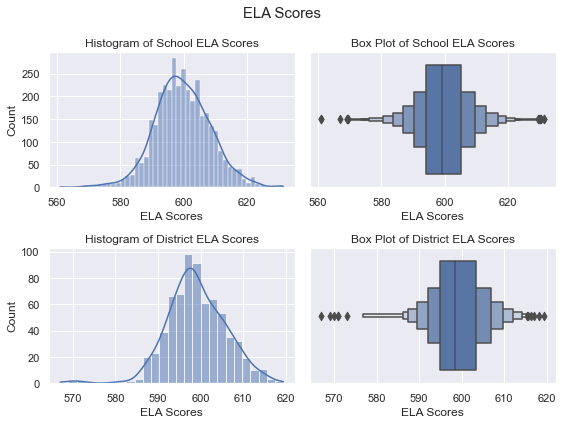

In [76]:
plotter('ELA Scores')

These are the distributions of English Language Arts (ELA) Scores at the school level and at the district level. They are fairly close to normal, with the district level graph having a slight skew.

### Mathematics Scores

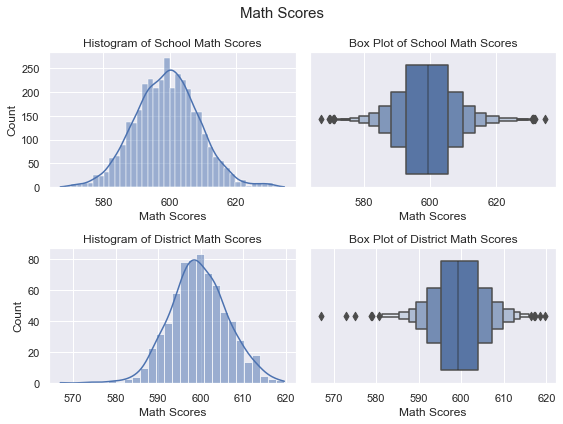

In [77]:
plotter('Math Scores')

These are the distributions of Mathematics Scores at the school level and at the district level. They are fairly close to normal.

### Average Class Sizes

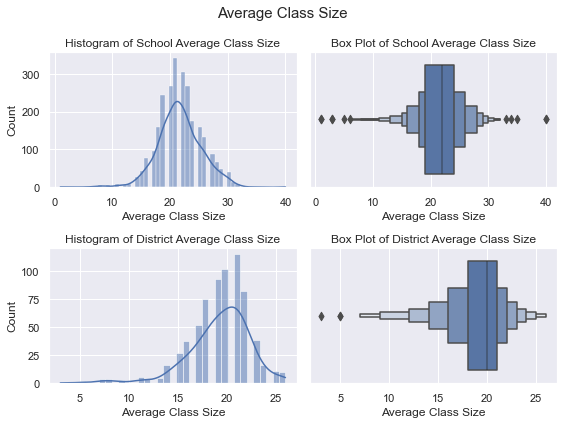

In [78]:
plotter('Average Class Size')

These are the distributions of Average Class Sizes at the school level and at the district level. They are unimodal with a peak slightly above 20. The district level distribution has a slight left skew.

### Attendance Rate

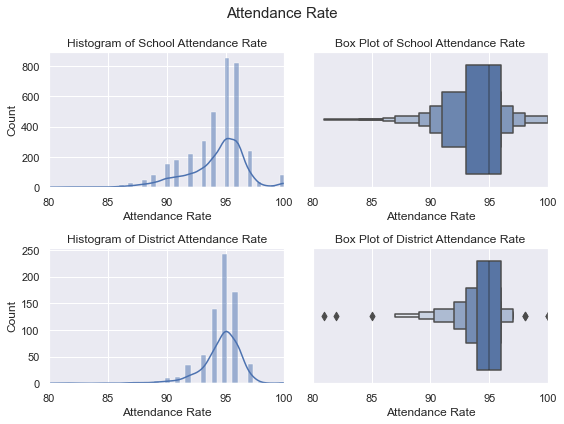

In [79]:
plotter('Attendance Rate', [80, 100])

These are the distributions of Attendance Rates at the school level and at the district level. They are generally high with modes around 95%, but low-attendance outliers at both levels create a noticeable left skew.

### Suspension Rate

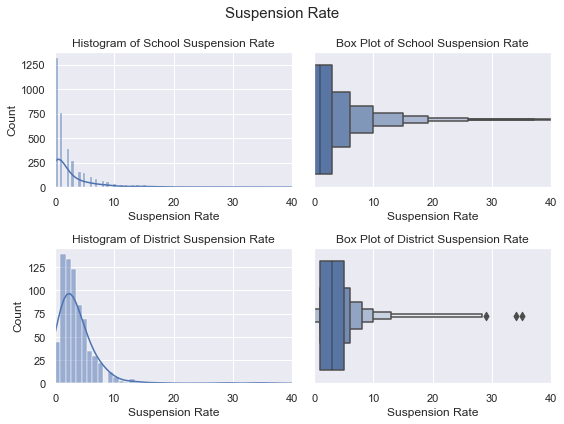

In [80]:
plotter('Suspension Rate', [0, 40])

These are the distributions of Suspension Rates at the school level and at the district level. They are generally low but as with Attendance Rates, small numbers of extreme outliers give these distributions a long tail.

### Free Lunch Rate

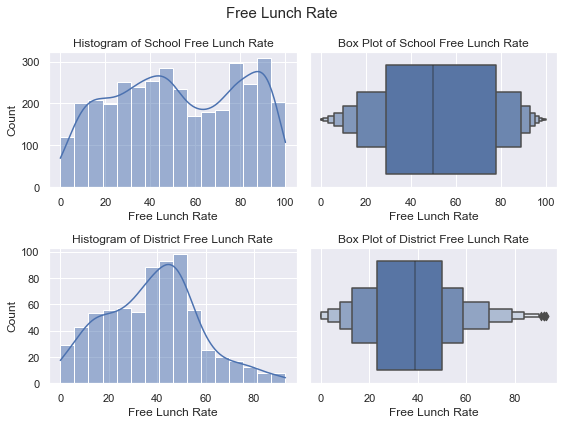

In [81]:
plotter('Free Lunch Rate')

These are the distributions of Free Lunch Rates at the school level and at the district level. These graphs differ heavily and have somewhat chaotic shapes. The most notable characteristic for this variable is a broad interquartile range.

### Teacher Pay

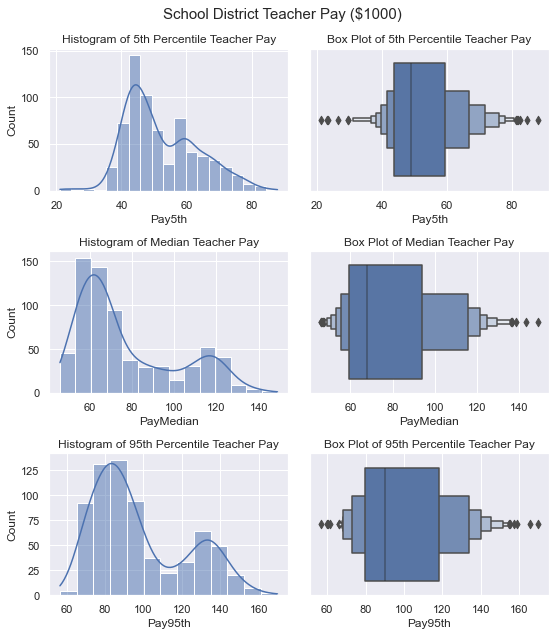

In [82]:
plt.figure(figsize = (8,9))
plt.suptitle('School District Teacher Pay ($1000)', size = 15)

plt.subplot(3,2,1)
plt.title('Histogram of 5th Percentile Teacher Pay')
sns.histplot(x = districtsEDA['Pay5th']/1000, kde = True)
plt.subplot(3,2,2)
plt.title('Box Plot of 5th Percentile Teacher Pay')
sns.boxenplot(x = districtsEDA['Pay5th']/1000)

plt.subplot(3,2,3)
plt.title('Histogram of Median Teacher Pay')
sns.histplot(x = districtsEDA['PayMedian']/1000, kde = True)
plt.subplot(3,2,4)
plt.title('Box Plot of Median Teacher Pay')
sns.boxenplot(x = districtsEDA['PayMedian']/1000)

plt.subplot(3,2,5)
plt.title('Histogram of 95th Percentile Teacher Pay')
sns.histplot(x = districtsEDA['Pay95th']/1000, kde = True)
plt.subplot(3,2,6)
plt.title('Box Plot of 95th Percentile Teacher Pay')
sns.boxenplot(x = districtsEDA['Pay95th']/1000)

plt.tight_layout()

These are the distributions of Teacher Pay at the school district level, represented at the 5th percentile, median and 95th percentile of all the teachers in each district. These are noticeably bimodal in all three representations.

### Distributional Transformations - Not Required

Our numerical data has a variety of distributions, some of which are close to Gaussian, others which are not. They also exist at vastly different scales.

However, our research questions do not involve predictive/inference modeling and thus we have no need to make our data conform to Gaussian assumptions or be normalized to a common scale.

As such, we choose to let our data set remain as-is without using any power transforms or normalization.

## Categorical Attributes

### County

<AxesSubplot:title={'center':'School Count by County'}, xlabel='County', ylabel='count'>

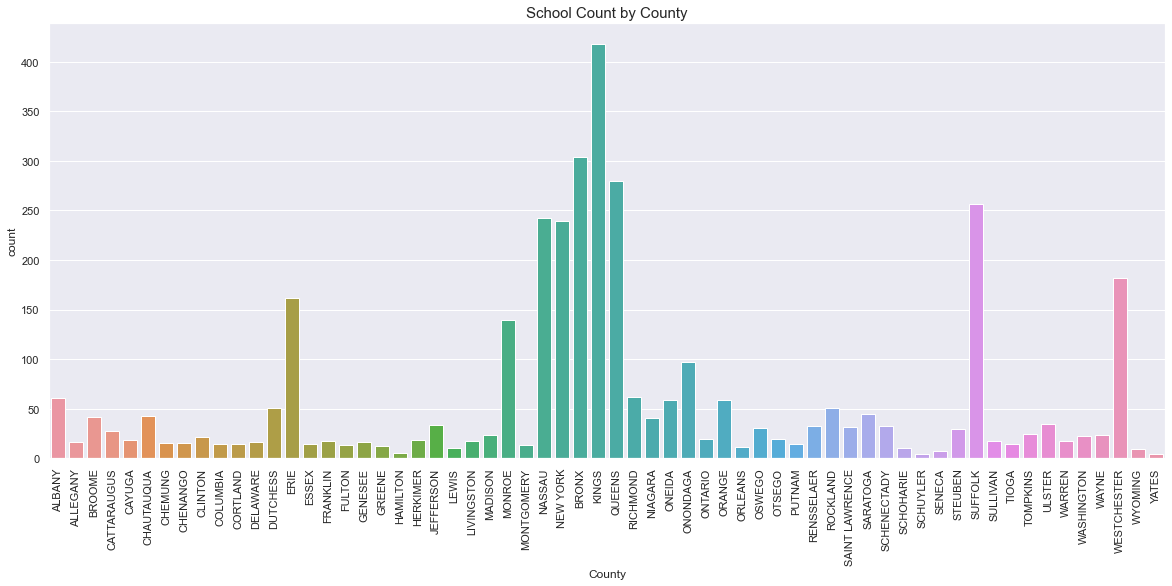

In [83]:
sns.set_style("darkgrid")

plt.figure(figsize = (20,8))
plt.title('School Count by County', size = 15)
plt.xticks(rotation = 90)
sns.countplot(x = 'County', data = schoolsEDA)

<AxesSubplot:title={'center':'School District Count by County'}, xlabel='County', ylabel='count'>

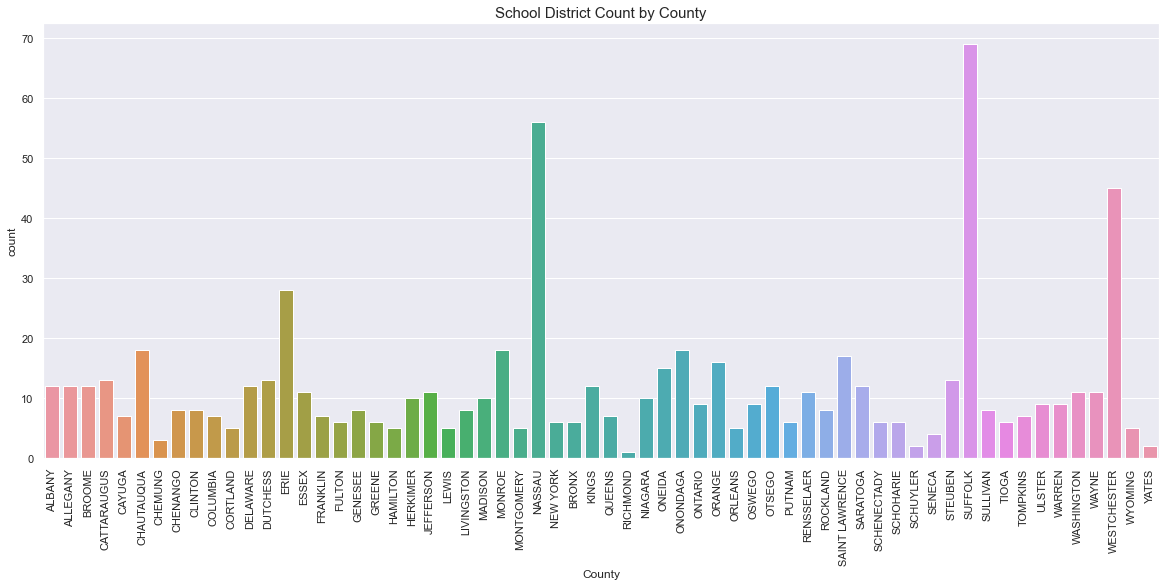

In [84]:
plt.figure(figsize = (20,8))
plt.title('School District Count by County', size = 15)
plt.xticks(rotation = 90)
sns.countplot(x = 'County', data = districtsEDA)

The distributions of schools and school districts by county differ heavily, and a quick visual inspection reveals the reason for this difference: New York City and its boroughs. NYC has a very large number of schools managed by a relatively small number of separate districts. If NYC is ignored, the school and district distributions by county look quite similar to one another.

### Needs/Resource Capacity (N/RC) Category

<AxesSubplot:title={'center':'School Count by N/RC Category'}, xlabel='N/RC', ylabel='count'>

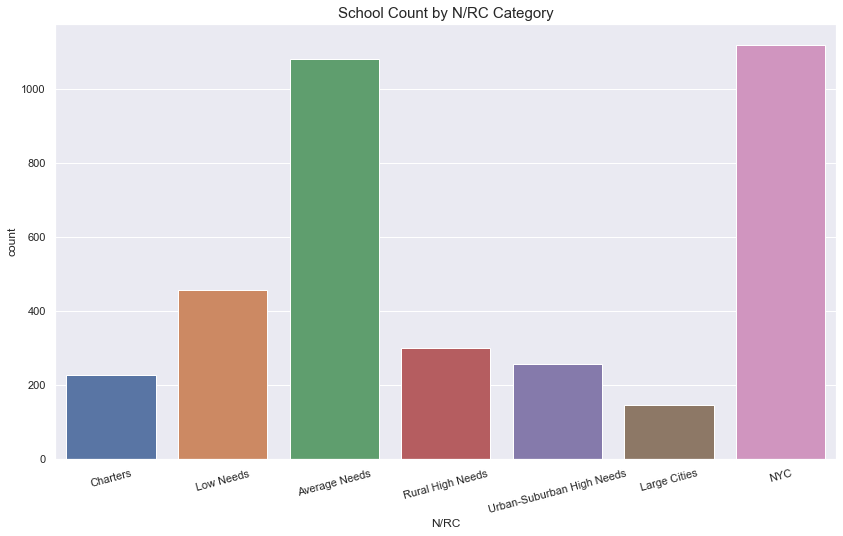

In [85]:
schoolsGraph['N/RC'] = schoolsGraph['N/RC'].str.replace(pat = "Buffalo, Rochester, Yonkers, Syracuse", repl = "Large Cities")

ordinal = ('Charters', 'Low Needs', 'Average Needs', 'Rural High Needs',
           'Urban-Suburban High Needs', 'Large Cities', 'NYC')

plt.figure(figsize = (14,8))
plt.title('School Count by N/RC Category', size = 15)
plt.xticks(rotation = 15)
sns.countplot(x = 'N/RC', data = schoolsGraph, order = ordinal)

<AxesSubplot:title={'center':'School District Count by N/RC Category'}, xlabel='N/RC', ylabel='count'>

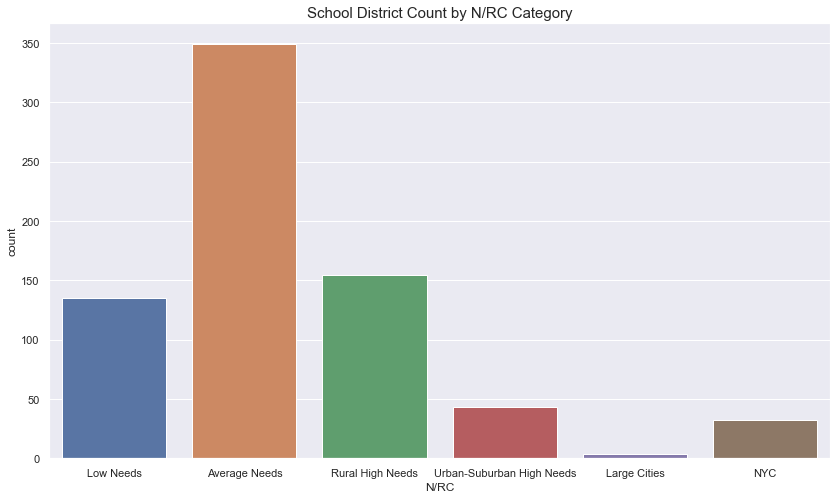

In [86]:
districtsGraph['N/RC'] = districtsGraph['N/RC'].str.replace(pat = "Buffalo, Rochester, Yonkers, Syracuse",
                                                            repl = "Large Cities")

ordinal = ('Low Needs', 'Average Needs', 'Rural High Needs',
           'Urban-Suburban High Needs', 'Large Cities', 'NYC')

plt.figure(figsize = (14,8))
plt.title('School District Count by N/RC Category', size = 15)
sns.countplot(x = 'N/RC', data = districtsGraph, order = ordinal)

The difference in N/RC classification distributions at the school and district levels reveals the same fact that the county distribution showed: NYC has a huge number of schools (which are considered to be at the highest Needs/Resources ratio), but a small number of school districts. Charter schools are independent of school districts and thus do not have a district-level N/RC representation.

# Part 3: Investigative Analysis & Results

The investigations we conduct for our research questions can broadly be split into categories: Conditional and Relations.

In our Conditional analysis, we use our data conditioned by socio-economic subgroups to show direct visual comparisons between those subgroups.

In our Relations analysis, we investigate the relationships between attributes in our data set and note any conclusions that can be extracted from those relationships.

## Conditional Data Investigation

Conditional data extraction:

In [87]:
# All Students
allstudents_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'All Students') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
allstudents_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'All Students') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]

# Gender
female_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Female') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
male_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Male') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
female_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Female') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
male_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Male') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]

# Race
amerin_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'American Indian or Alaska Native') &
                      (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
amerin_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'American Indian or Alaska Native') &
                     (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
black_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Black or African American') &
                    (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
black_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Black or African American') &
                     (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
asian_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Asian or Pacific Islander') &
                    (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
asian_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Asian or Pacific Islander') &
                     (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
white_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'White') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
white_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'White') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
multi_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Multiracial') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
multi_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Multiracial') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]

# Disability
disab_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Students with Disabilities') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
disab_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Students with Disabilities') &
                     (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]

# English Language Learner
nell_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Not English Language Learner') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
nell_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Not English Language Learner') &
                    (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
ell_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'English Language Learner') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
ell_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'English Language Learner') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]

# Economic Disadvantage
ecodis_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Economically Disadvantaged') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
ecodis_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Economically Disadvantaged') &
                      (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
necodis_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Not Economically Disadvantaged') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
necodis_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Not Economically Disadvantaged') &
                       (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]

# Migrant
migrant_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Migrant') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
migrant_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Migrant') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]
nmig_ela = dtest38[(dtest38['SUBGROUP_NAME'] == 'Not Migrant') & (dtest38['ITEM_SUBJECT_AREA'] == 'ELA')]
nmig_math = dtest38[(dtest38['SUBGROUP_NAME'] == 'Not Migrant') & (dtest38['ITEM_SUBJECT_AREA'] == 'Mathematics')]

### Aggregate Math vs ELA Scores

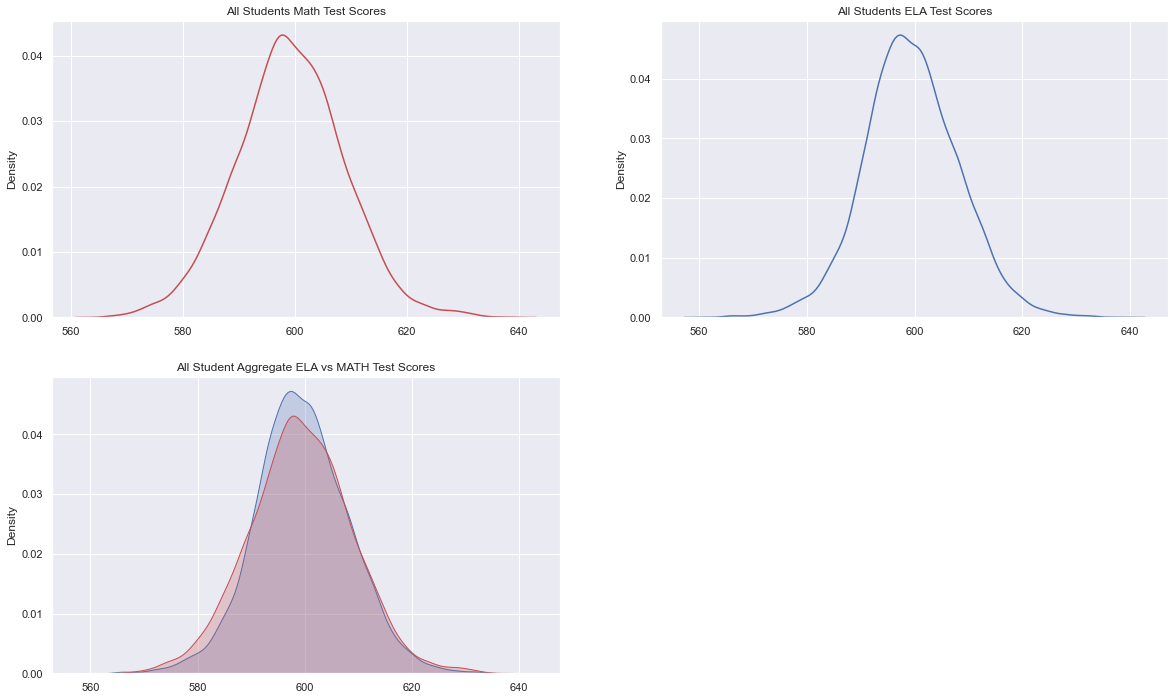

In [88]:
plt.figure(figsize = (20,12))
plt.subplot(2,2,1)
plt.title('All Students Math Test Scores')
sns.kdeplot(x = allstudents_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(2,2,2)
plt.title('All Students ELA Test Scores')
sns.kdeplot(x = allstudents_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(2,2,3)
plt.title('All Student Aggregate ELA vs MATH Test Scores')
sns.kdeplot(x = allstudents_ela.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
sns.kdeplot(x = allstudents_math.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
plt.show()

Math scores are in red, ELA scores are in blue.

Based on the graph, Math scores have a wider distribution than ELA scores but with an slight left tail, so we can presume that a slightly larger proportion of students score poorly in Math than in ELA.

### Test Scores by Gender

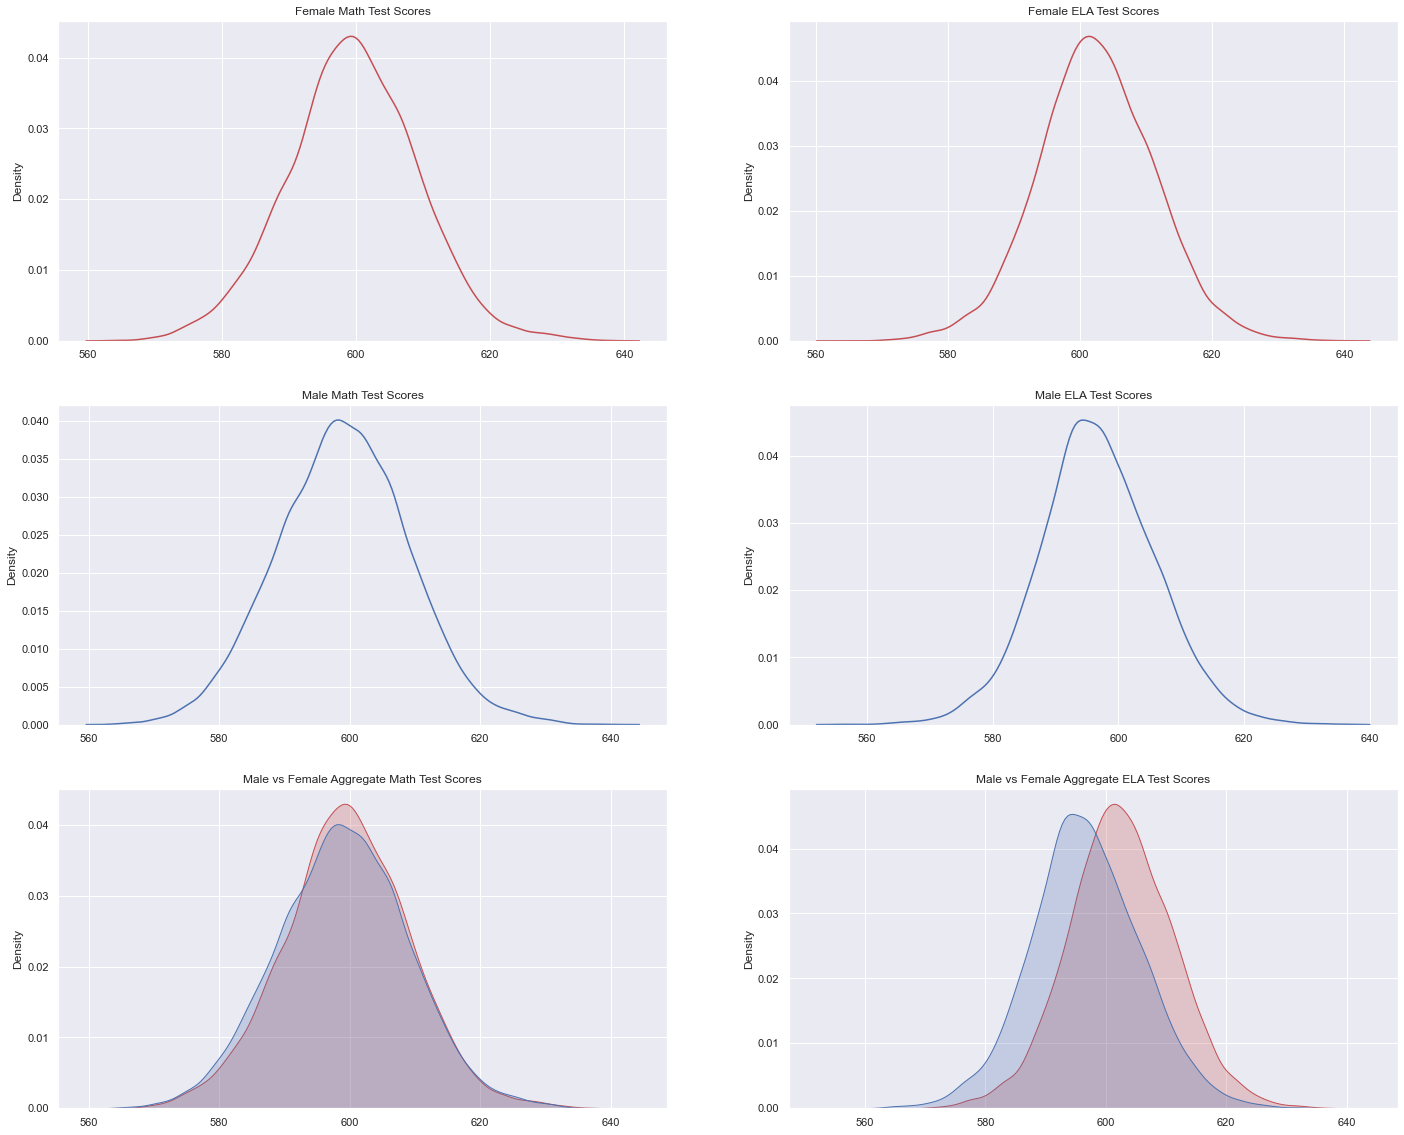

In [89]:
plt.figure(figsize = (24,20))
plt.subplot(3,2,1)
plt.title('Female Math Test Scores')
sns.kdeplot(x = female_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(3,2,3)
plt.title('Male Math Test Scores')
sns.kdeplot(x = male_math.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(3,2,2)
plt.title('Female ELA Test Scores')
sns.kdeplot(x = female_ela.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(3,2,4)
plt.title('Male ELA Test Scores')
sns.kdeplot(x = male_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(3,2,5)
plt.title('Male vs Female Aggregate Math Test Scores')
sns.kdeplot(x = female_math.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = male_math.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.subplot(3,2,6)
plt.title('Male vs Female Aggregate ELA Test Scores')
sns.kdeplot(x = female_ela.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = male_ela.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.show()

Female students' scores are in red, male students' scores are in blue.

Based on gender, we observe that both boys and girls are almost equal in the Math scores distribution, but if we look closely we see that boys' scores have a *slight* left tail. Whereas, in ELA scores it is quite apparent that girls have higher scores than boys.

### Test Scores by Race/Ethnicity

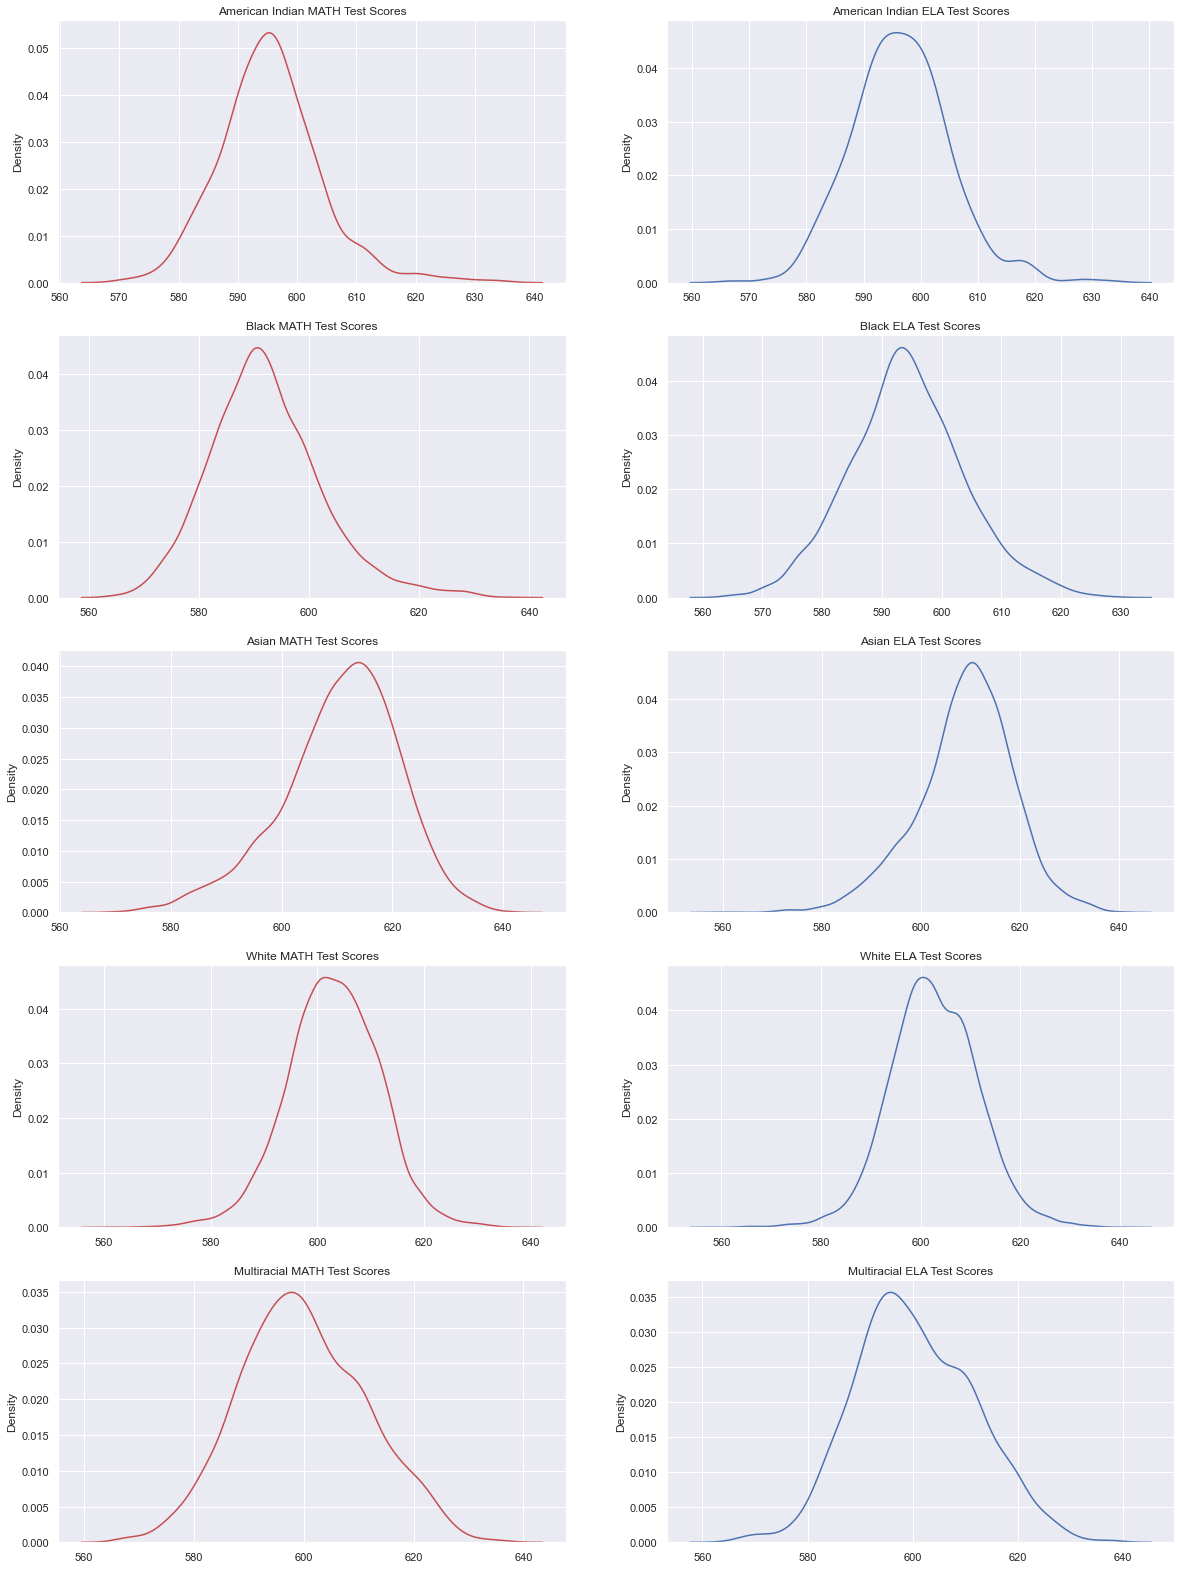

In [90]:
plt.figure(figsize = (20,28))
plt.subplot(5,2,1)
plt.title('American Indian MATH Test Scores')
sns.kdeplot(x = amerin_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(5,2,2)
plt.title('American Indian ELA Test Scores')
sns.kdeplot(x = amerin_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(5,2,3)
plt.title('Black MATH Test Scores')
sns.kdeplot(x = black_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(5,2,4)
plt.title('Black ELA Test Scores')
sns.kdeplot(x = black_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(5,2,5)
plt.title('Asian MATH Test Scores')
sns.kdeplot(x = asian_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(5,2,6)
plt.title('Asian ELA Test Scores')
sns.kdeplot(x = asian_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(5,2,7)
plt.title('White MATH Test Scores')
sns.kdeplot(x = white_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(5,2,8)
plt.title('White ELA Test Scores')
sns.kdeplot(x = white_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(5,2,9)
plt.title('Multiracial MATH Test Scores')
sns.kdeplot(x = multi_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(5,2,10)
plt.title('Multiracial ELA Test Scores')
sns.kdeplot(x = multi_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.show()

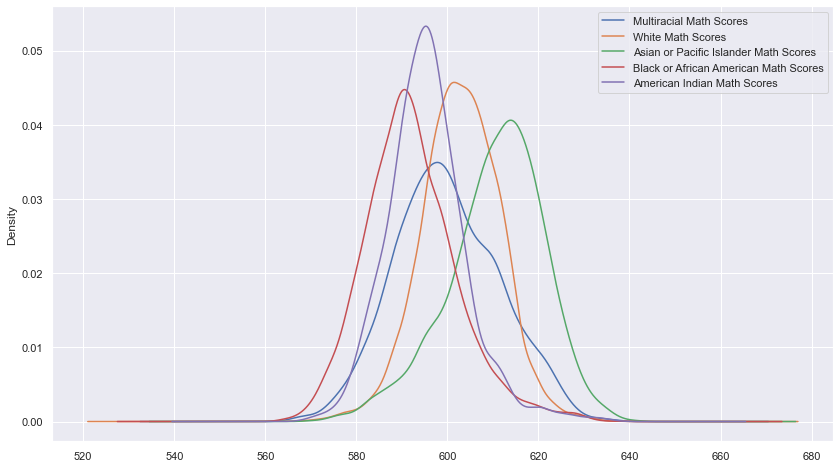

In [91]:
multi_math['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='Multiracial Math Scores')
white_math['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='White Math Scores')
asian_math['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='Asian or Pacific Islander Math Scores')
black_math['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='Black or African American Math Scores')
amerin_math['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='American Indian Math Scores')
plt.legend()

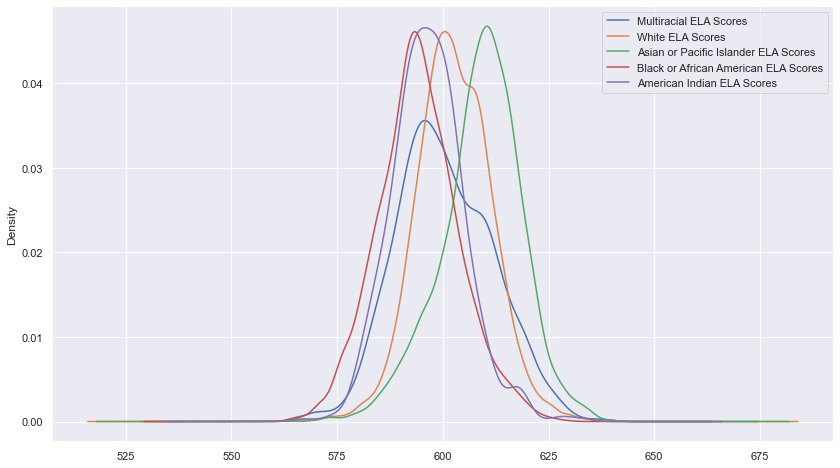

In [92]:
multi_ela['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='Multiracial ELA Scores')
white_ela['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='White ELA Scores')
asian_ela['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='Asian or Pacific Islander ELA Scores')
black_ela['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='Black or African American ELA Scores')
amerin_ela['MEAN_SCALE_SCORE'].plot(kind='kde', figsize=(14,8), label='American Indian ELA Scores')
plt.legend()

Based on the different racial groups represented in the data acquired, we observe that two minority groups have outlying average scores for *both* Math and ELA statewide. Asian-American students do significantly better in both Math and ELA scores. Black/African American students score lowest on both Math and ELA statewide. Additonally, the largest ethnic group (White students, at 43% of the student population) is clustered in the middle.

### Test Scores by English Language Learner Status

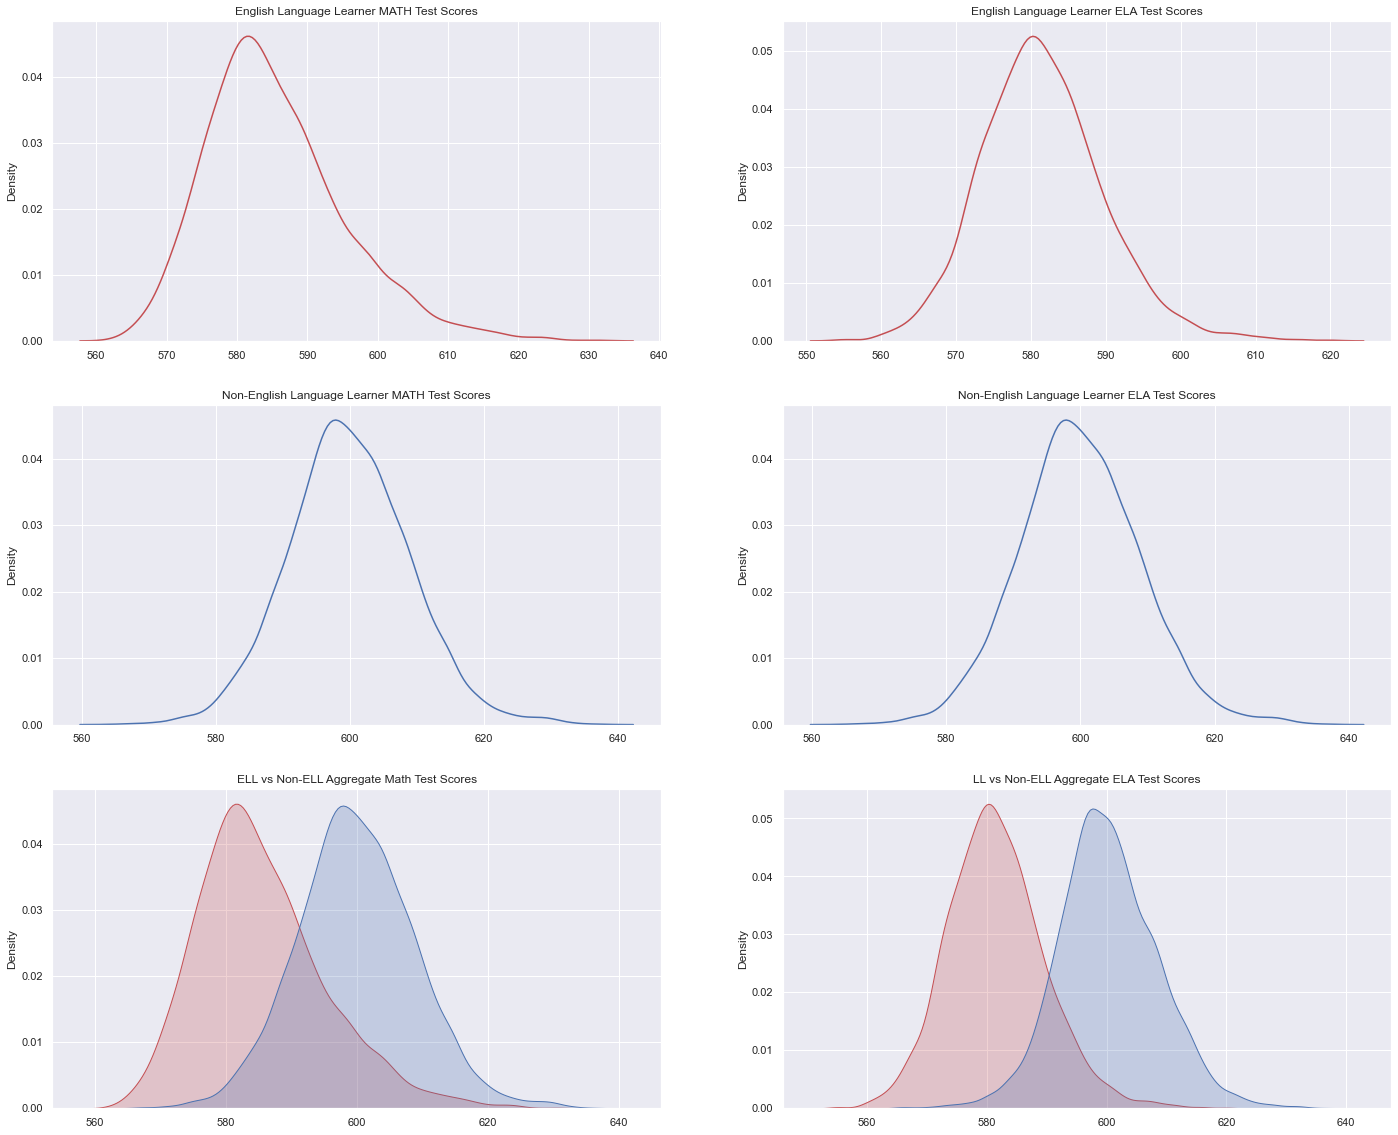

In [93]:
plt.figure(figsize = (24,20))
plt.subplot(3,2,1)
plt.title('English Language Learner MATH Test Scores')
sns.kdeplot(x = ell_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(3,2,2)
plt.title('English Language Learner ELA Test Scores')
sns.kdeplot(x = ell_ela.MEAN_SCALE_SCORE, color='r').set(xlabel=None)
plt.subplot(3,2,3)
plt.title('Non-English Language Learner MATH Test Scores')
sns.kdeplot(x = nell_math.MEAN_SCALE_SCORE, color ='b').set(xlabel=None)
plt.subplot(3,2,4)
plt.title('Non-English Language Learner ELA Test Scores')
sns.kdeplot(x = nell_math.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(3,2,5)
plt.title('ELL vs Non-ELL Aggregate Math Test Scores')
sns.kdeplot(x = ell_math.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = nell_math.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.subplot(3,2,6)
plt.title('LL vs Non-ELL Aggregate ELA Test Scores')
sns.kdeplot(x = ell_ela.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = nell_ela.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.show()

ELL students' scores are in red, non-ELL students' scores are in blue.

ELL students have a significant disadvantage in both Math and ELA scores. Not surprisingly, they do worse by a greater margin on ELA than on Math when compared with non-ELL students. Here we also see narrower distributions of scores, so there is relatively little overlap in the kernel density of the two groups.

### Test Scores for Students with Disabilities

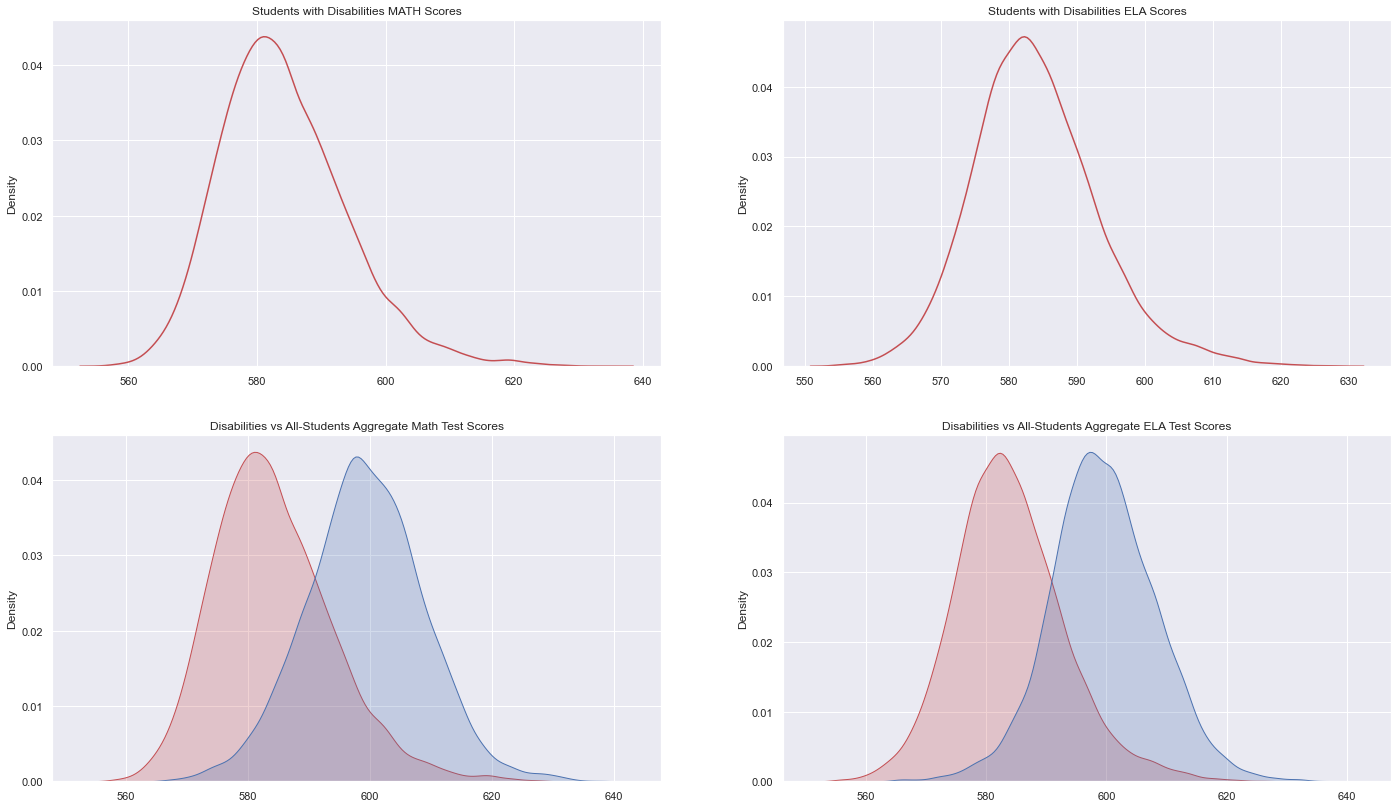

In [94]:
plt.figure(figsize = (24,14))
plt.subplot(2,2,1)
plt.title('Students with Disabilities MATH Scores')
sns.kdeplot(x = disab_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(2,2,2)
plt.title('Students with Disabilities ELA Scores')
sns.kdeplot(x = disab_ela.MEAN_SCALE_SCORE, color='r').set(xlabel=None)
plt.subplot(2,2,3)
plt.title('Disabilities vs All-Students Aggregate Math Test Scores')
sns.kdeplot(x = disab_math.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = allstudents_math.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.subplot(2,2,4)
plt.title('Disabilities vs All-Students Aggregate ELA Test Scores')
sns.kdeplot(x = disab_ela.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = allstudents_ela.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.show()

Since there is no non-disability category in the data, we plotted a comparison with the average of All-Students scores. This implies that there is double counting, but since disability is represented in only 18% of the state's student body we decided to go ahead with the comparison.

Both Math and ELA scores are significantly lower for students with disabilities than the average overall. 

### Test Scores by Student Economic Status

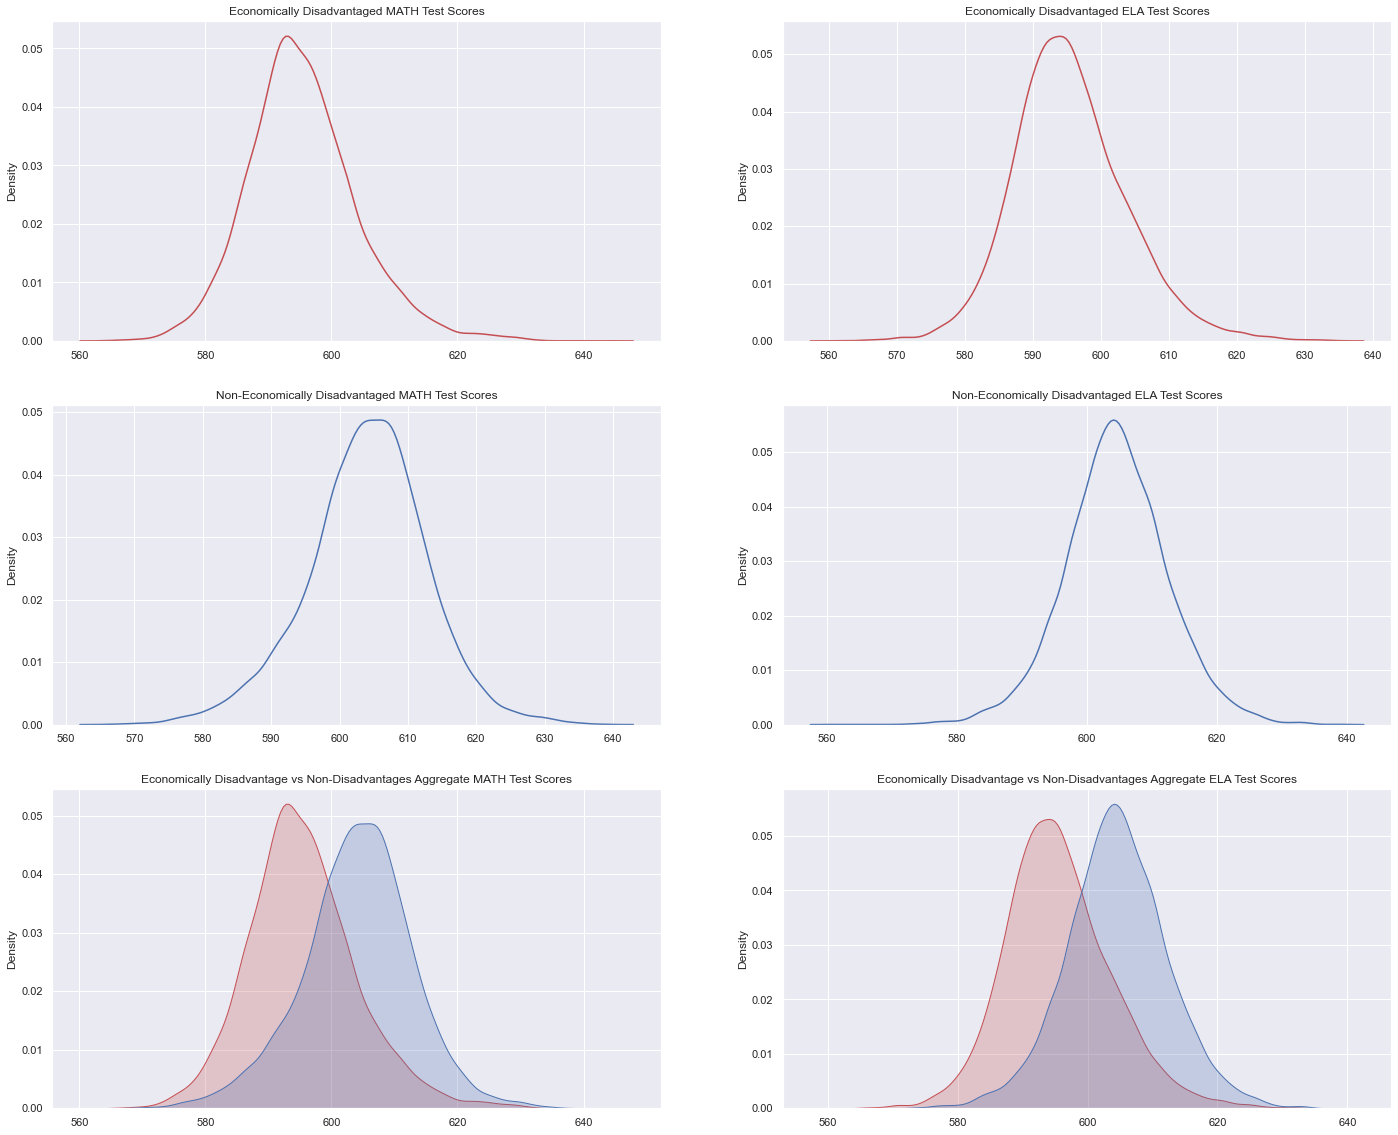

In [95]:
plt.figure(figsize = (24,20))
plt.subplot(3,2,1)
plt.title('Economically Disadvantaged MATH Test Scores')
sns.kdeplot(x = ecodis_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(3,2,2)
plt.title('Economically Disadvantaged ELA Test Scores')
sns.kdeplot(x = ecodis_ela.MEAN_SCALE_SCORE, color='r').set(xlabel=None)
plt.subplot(3,2,3)
plt.title('Non-Economically Disadvantaged MATH Test Scores')
sns.kdeplot(x = necodis_math.MEAN_SCALE_SCORE, color ='b').set(xlabel=None)
plt.subplot(3,2,4)
plt.title('Non-Economically Disadvantaged ELA Test Scores')
sns.kdeplot(x = necodis_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(3,2,5)
plt.title('Economically Disadvantage vs Non-Disadvantages Aggregate MATH Test Scores')
sns.kdeplot(x = ecodis_math.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = necodis_math.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.subplot(3,2,6)
plt.title('Economically Disadvantage vs Non-Disadvantages Aggregate ELA Test Scores')
sns.kdeplot(x = ecodis_ela.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = necodis_ela.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.show()

Economically disadvantaged students' scores are in red, non-disadvantaged students' scores are in blue.

We note that a _majority_ of New York State's public school students (_57%_) are labelled as 'economically disadvantaged'. Here we observe a significant disparity in both ELA and Math scores statewide when comparing to non-economically-disadvantaged students.

### Test Scores by Student Migrant Status

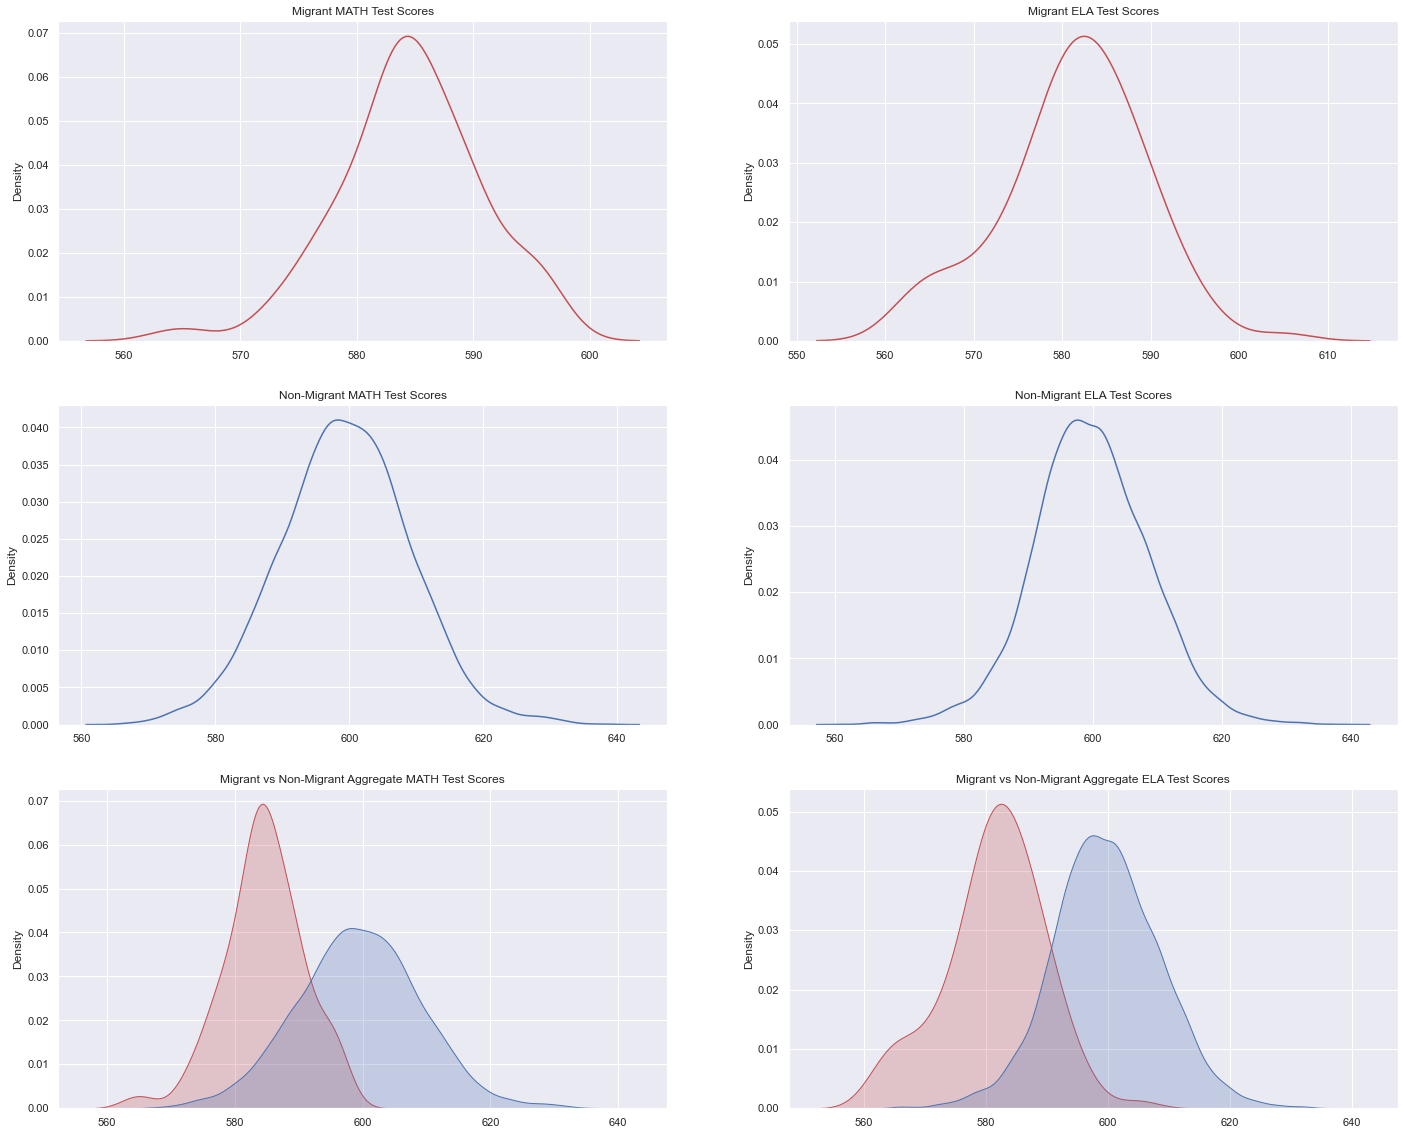

In [96]:
plt.figure(figsize = (24,20))
plt.subplot(3,2,1)
plt.title('Migrant MATH Test Scores')
sns.kdeplot(x = migrant_math.MEAN_SCALE_SCORE, color ='r').set(xlabel=None)
plt.subplot(3,2,2)
plt.title('Migrant ELA Test Scores')
sns.kdeplot(x = migrant_ela.MEAN_SCALE_SCORE, color='r').set(xlabel=None)
plt.subplot(3,2,3)
plt.title('Non-Migrant MATH Test Scores')
sns.kdeplot(x = nmig_math.MEAN_SCALE_SCORE, color ='b').set(xlabel=None)
plt.subplot(3,2,4)
plt.title('Non-Migrant ELA Test Scores')
sns.kdeplot(x = nmig_ela.MEAN_SCALE_SCORE, color='b').set(xlabel=None)
plt.subplot(3,2,5)
plt.title('Migrant vs Non-Migrant Aggregate MATH Test Scores')
sns.kdeplot(x = migrant_math.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = nmig_math.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.subplot(3,2,6)
plt.title('Migrant vs Non-Migrant Aggregate ELA Test Scores')
sns.kdeplot(x = migrant_ela.MEAN_SCALE_SCORE, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = nmig_ela.MEAN_SCALE_SCORE, fill=True, color="b").set(xlabel=None)
plt.show()

Migrant students' scores are in red, non-migrant students' scores are in blue.

We note that migrant students number only about 1,800, out of nearly 1.2 million students in New York State. This is less than 1% of all students.

We observe that migrant students' scores are significantly lower in both Math and ELA. They have a narrower distribution than that of non-migrant students, and have a slight left-tail.

## Data Relations Investigation

### Correlation Matrix

In [97]:
schoolsCorr = schoolsEDA.corr()

schoolsCorr

,ELA,Mathematics,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
ELA,1.000000,0.928753,0.215879,0.585286,-0.313711,-0.578318
Mathematics,0.928753,1.000000,0.183730,0.652966,-0.267308,-0.606639
AvgClassSize,0.215879,0.183730,1.000000,0.081454,-0.049538,0.143909
Attendance%,0.585286,0.652966,0.081454,1.000000,-0.205318,-0.576904
Suspensions%,-0.313711,-0.267308,-0.049538,-0.205318,1.000000,0.181389
FreeLunch%,-0.578318,-0.606639,0.143909,-0.576904,0.181389,1.000000


<AxesSubplot:>

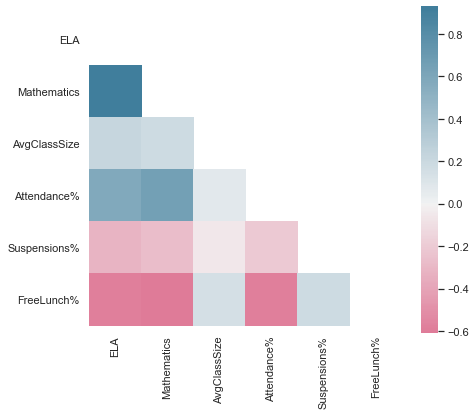

In [98]:
sns.set_style("white")

# Upper triangular mask
mask = np.triu(np.ones_like(schoolsCorr, dtype = bool))

fig, axes = plt.subplots(figsize=(7, 6))

# Diverging colormap
cmap = sns.diverging_palette(0, 230, as_cmap = True)

# Heatmap with mask and colormap applied
sns.heatmap(schoolsCorr, mask = mask, cmap = cmap, center = 0, square = True)

In [99]:
districtsCorr = districtsEDA.corr()

districtsCorr

,ELA,Mathematics,Pay5th,PayMedian,Pay95th,AvgClassSize,Attendance%,Suspensions%,FreeLunch%
ELA,1.000000,0.928269,0.362821,0.438906,0.401481,0.188157,0.579252,-0.404937,-0.729422
Mathematics,0.928269,1.000000,0.311305,0.373196,0.349840,0.109966,0.589445,-0.379629,-0.762063
Pay5th,0.362821,0.311305,1.000000,0.842285,0.749471,0.410649,0.042158,-0.109592,-0.310534
PayMedian,0.438906,0.373196,0.842285,1.000000,0.937072,0.409757,0.163021,-0.129569,-0.462991
Pay95th,0.401481,0.349840,0.749471,0.937072,1.000000,0.333560,0.214753,-0.089953,-0.507665
AvgClassSize,0.188157,0.109966,0.410649,0.409757,0.333560,1.000000,0.012627,-0.161172,-0.025147
Attendance%,0.579252,0.589445,0.042158,0.163021,0.214753,0.012627,1.000000,-0.436980,-0.571493
Suspensions%,-0.404937,-0.379629,-0.109592,-0.129569,-0.089953,-0.161172,-0.436980,1.000000,0.310584
FreeLunch%,-0.729422,-0.762063,-0.310534,-0.462991,-0.507665,-0.025147,-0.571493,0.310584,1.000000


<AxesSubplot:>

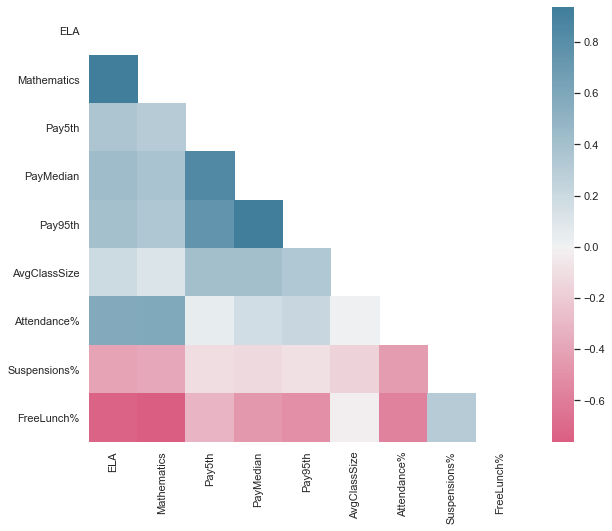

In [100]:
mask = np.triu(np.ones_like(districtsCorr, dtype = bool))
fig, axes = plt.subplots(figsize=(10, 8))

cmap = sns.diverging_palette(0, 230, as_cmap = True)

sns.heatmap(districtsCorr, mask = mask, cmap = cmap, center = 0, square = True)

We observe that the pattern of correlations is more or less the same at both aggregation levels - school and district.

We see that ELA and Math Scores are highly positively correlated to each other, but negatively correlated to Free Lunch Rates, which implies a narrative of students in schools/districts which have free lunch programs (who are likely less affluent) doing relatively poorly on assessments.

Attendance Rates meanwhile are positively correlated with Scores, and Suspension Rates are negatively correlated, but the magnitudes of these correlations are quite weak. As such, we choose to forgo further visualizations involving these attributes.

Notably, Average Class Sizes have almost no correlation with _any_ other attribute.

### Teacher Pay vs Other Attributes

#### Teacher Pay by County

In [101]:
districtsEDA.columns

Index(['BEDSCODE', 'Name', 'County', 'N/RC', 'ELA', 'Mathematics', 'Pay5th',
       'PayMedian', 'Pay95th', 'AvgClassSize', 'Attendance%', 'Suspensions%',
       'FreeLunch%'],
      dtype='object')

<AxesSubplot:title={'center':'Teacher Pay by County'}, xlabel='County', ylabel='PayMedian'>

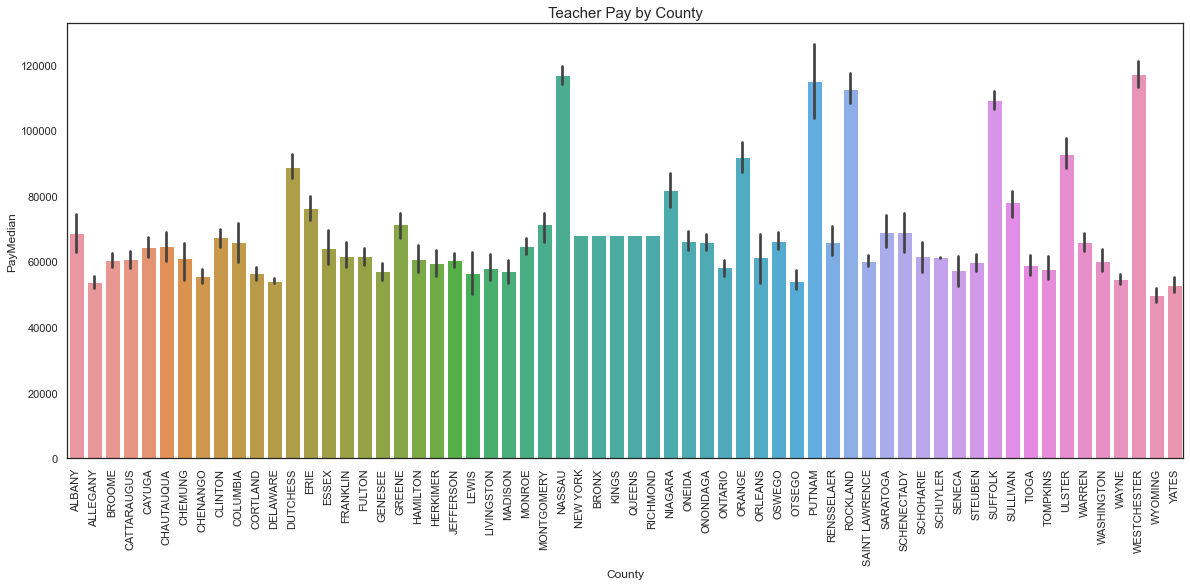

In [102]:
plt.figure(figsize = (20,8))
plt.title('Teacher Pay by County', size = 15)
plt.xticks(rotation = 90)
sns.barplot(x = 'County', y = 'PayMedian', data = districtsEDA)

When we look at Median Pay on the county level, we see that there are 5 counties that have aggregated median teacher salaries above $100,000 per annum. These counties, if separate from New YOrk State, would be the highest average teacher pay regions _in the world_ minus Luxenbourg.

Additionally, we see in this graph the result of all New York City school districts sharing the same source figures for teacher pay (from the NYC Chancellor's Office) - they appear as equal numbers with no error bars.

#### Teacher Pay by N/RC Category

<AxesSubplot:title={'center':'Teacher Pay by N/RC Category'}, xlabel='N/RC', ylabel='PayMedian'>

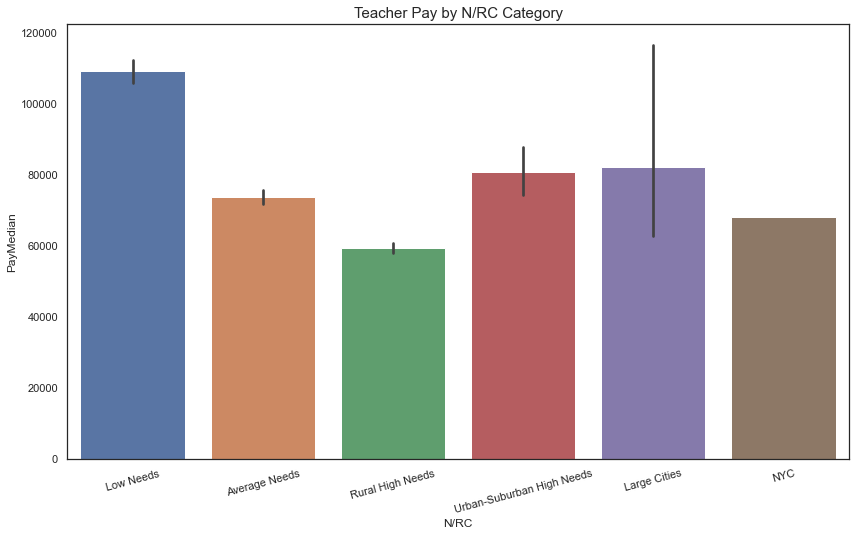

In [103]:
plt.figure(figsize = (14,8))
plt.title('Teacher Pay by N/RC Category', size = 15)
plt.xticks(rotation = 15)
sns.barplot(x = 'N/RC', y = 'PayMedian', data = districtsGraph, order = ordinal)

Not surprisingly, counties that are "Low Needs" have the highest paid teachers, whereas teachers in counties that are labeled "Rural High Needs" are paid the least. There is also signifcant Median Pay disparity _within_ New York's Large Cities (Buffalo, Rochester, Syacuse, Yonkers) school districts, as indicated by the wide error bar on that category.

#### Teacher Pay vs Scores

<AxesSubplot:title={'center':'Teacher Pay vs ELA Scores'}, xlabel='PayMedian', ylabel='ELA'>

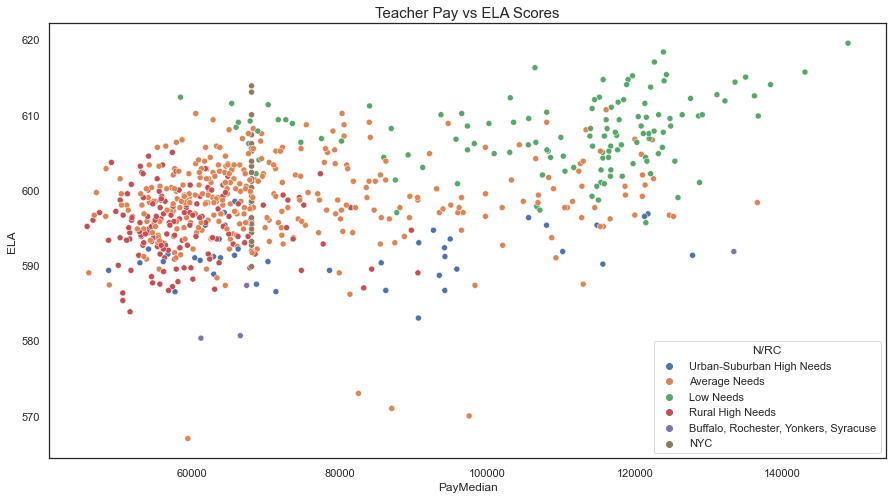

In [104]:
plt.figure(figsize = (15,8))
plt.title('Teacher Pay vs ELA Scores', size = 15)
sns.scatterplot(x = 'PayMedian', y = 'ELA', data = districtsEDA, hue = 'N/RC')

<AxesSubplot:title={'center':'Teacher Pay vs Mathematics Scores'}, xlabel='PayMedian', ylabel='Mathematics'>

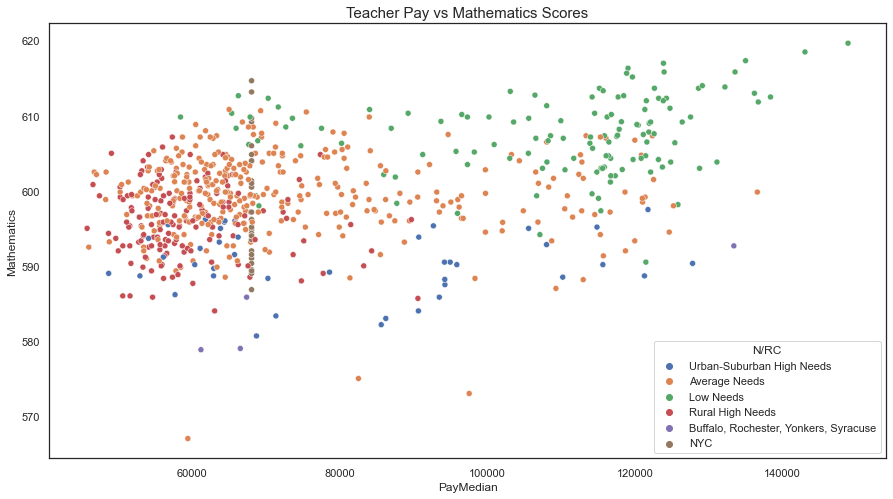

In [105]:
plt.figure(figsize = (15,8))
plt.title('Teacher Pay vs Mathematics Scores', size = 15)
sns.scatterplot(x = 'PayMedian', y = 'Mathematics', data = districtsEDA, hue = 'N/RC')

In the scatterplots of Teacher Pay vs Scores, we can see the bimodality of the Median Teacher Pay distribution through the fact that our datapoints come in two clusters: Low Needs / High Pay (green cluster) and Average-High Needs / Low Pay (orange-red cluster).

However, there is no strong linear relation between Teacher Pay and either Math or ELA Scores.

Even though the center of the green cluster indicates median salaries at almost twice the level of the orange-red cluster, the difference in scores are fairly small.

As the effects of teacher pay are one of our central research questions, we create some additional plots to observe the difference between the 'Low Needs' N/RC Category (which _appears_ to be correlated with high teacher pay, but is actually applied by the NYSED due to other socio-environmental factors) and a direct division of teacher pay into a very-high-pay bin (> $100,000 per annum) and an everyone-else bin.

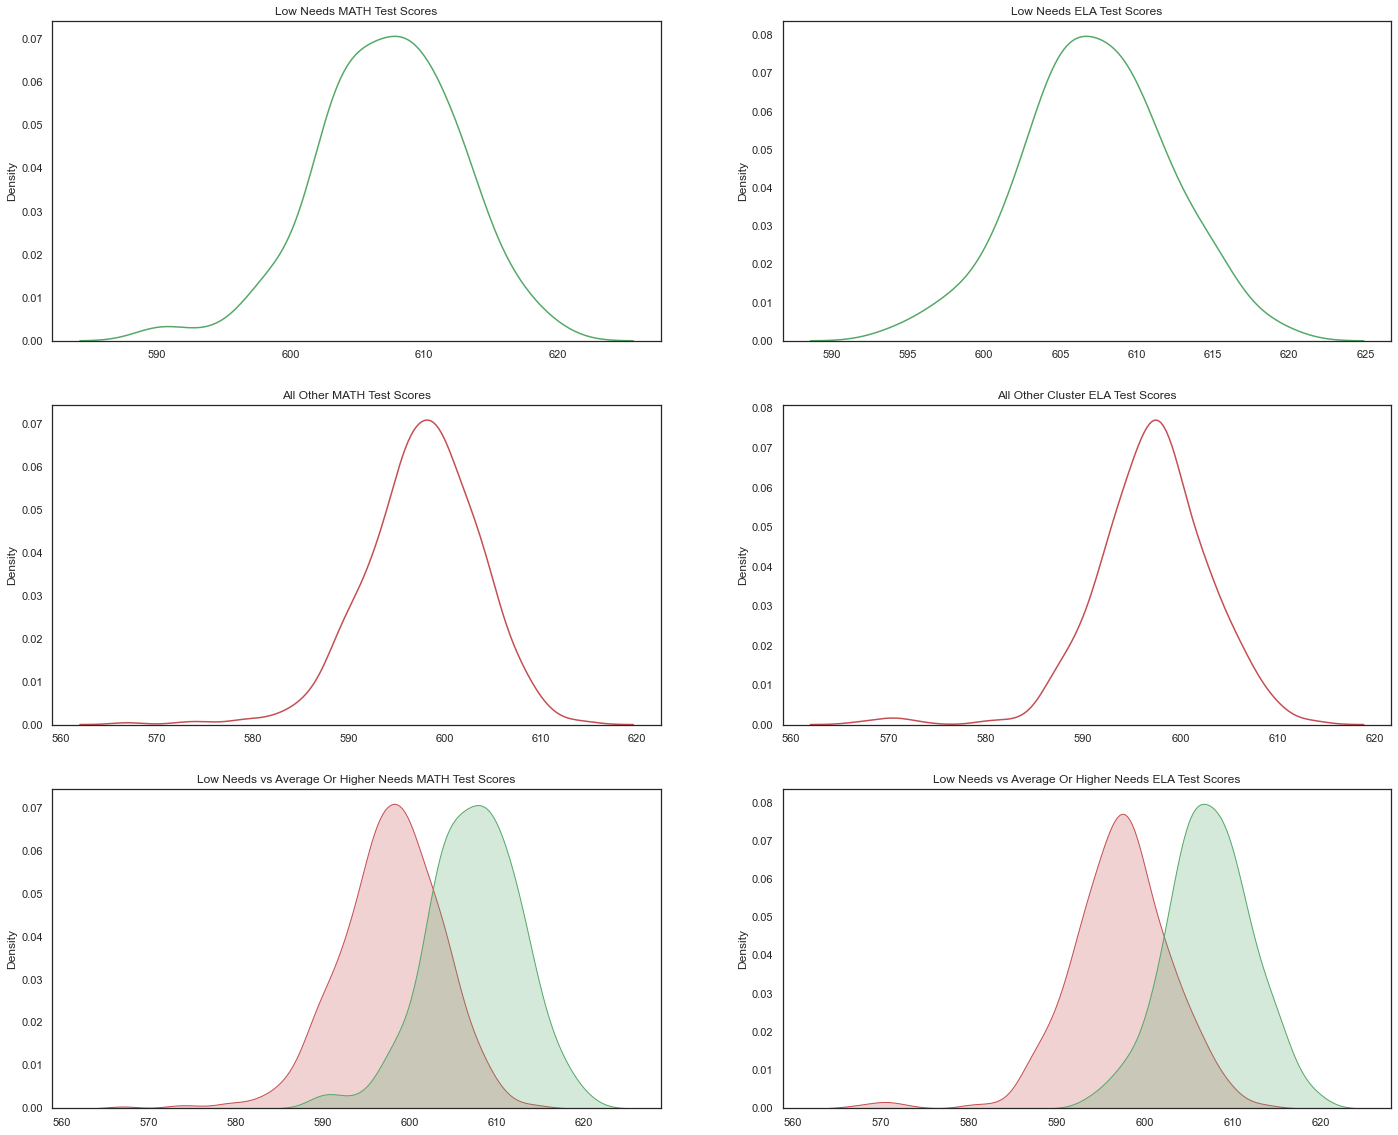

In [106]:
plt.figure(figsize = (24,20))
plt.subplot(3,2,1)
plt.title('Low Needs MATH Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] == 'Low Needs'].Mathematics, color ='g').set(xlabel=None)
plt.subplot(3,2,2)
plt.title('Low Needs ELA Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] == 'Low Needs'].ELA, color='g').set(xlabel=None)
plt.subplot(3,2,3)
plt.title('All Other MATH Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] != 'Low Needs'].Mathematics, color ='r').set(xlabel=None)
plt.subplot(3,2,4)
plt.title('All Other Cluster ELA Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] != 'Low Needs'].ELA, color='r').set(xlabel=None)
plt.subplot(3,2,5)
plt.title('Low Needs vs Average Or Higher Needs MATH Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] != 'Low Needs'].Mathematics, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] == 'Low Needs'].Mathematics, fill=True, color="g").set(xlabel=None)
plt.subplot(3,2,6)
plt.title('Low Needs vs Average Or Higher Needs ELA Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] != 'Low Needs'].ELA, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = districtsEDA[districtsEDA['N/RC'] == 'Low Needs'].ELA, fill=True, color="g").set(xlabel=None)
plt.show()

'Low Needs' students' scores are in green, all other students' scores are in red.

It is apparent that whatever factors lead to a 'Low Needs' N/RC categorization also lead to significantly higher test scores in both Math and ELA.

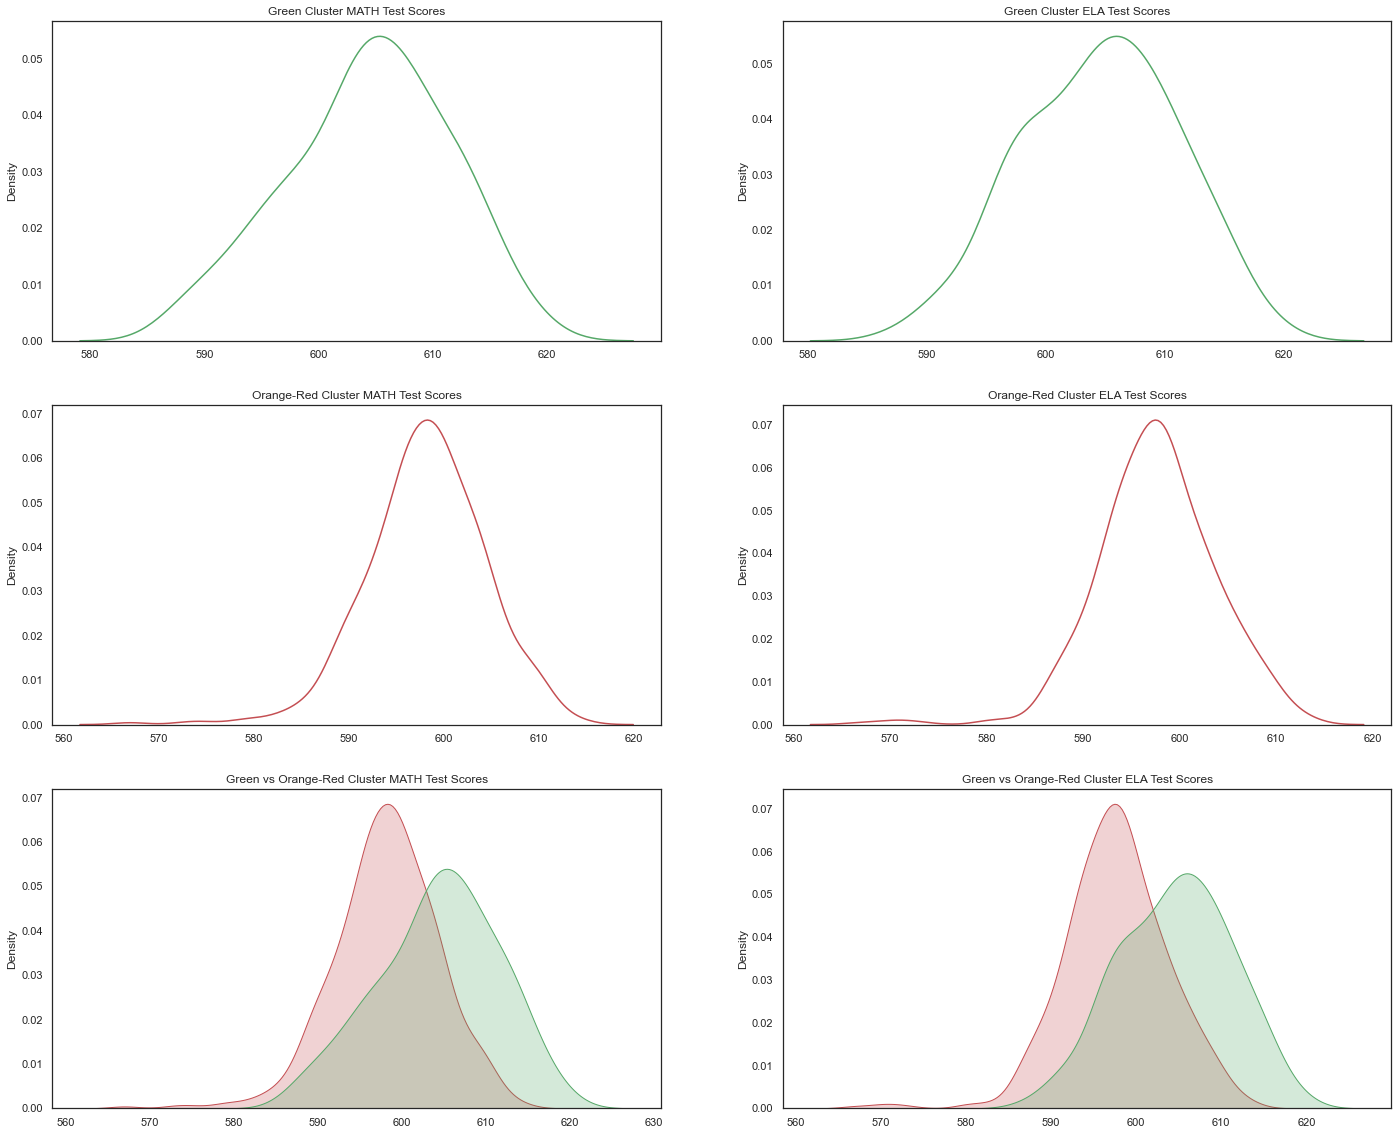

In [107]:
plt.figure(figsize = (24,20))
plt.subplot(3,2,1)
plt.title('Green Cluster MATH Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] >= 100000].Mathematics, color ='g').set(xlabel=None)
plt.subplot(3,2,2)
plt.title('Green Cluster ELA Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] >= 100000].ELA, color='g').set(xlabel=None)
plt.subplot(3,2,3)
plt.title('Orange-Red Cluster MATH Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] < 100000].Mathematics, color ='r').set(xlabel=None)
plt.subplot(3,2,4)
plt.title('Orange-Red Cluster ELA Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] < 100000].ELA, color='r').set(xlabel=None)
plt.subplot(3,2,5)
plt.title('Green vs Orange-Red Cluster MATH Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] < 100000].Mathematics, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] >= 100000].Mathematics, fill=True, color="g").set(xlabel=None)
plt.subplot(3,2,6)
plt.title('Green vs Orange-Red Cluster ELA Test Scores')
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] < 100000].ELA, fill=True, color="r").set(xlabel=None)
sns.kdeplot(x = districtsEDA[districtsEDA['PayMedian'] >= 100000].ELA, fill=True, color="g").set(xlabel=None)
plt.show()

Students taught by teachers paid (on median) above $100,000 per annum have their scores distribution in green, while students whose teachers make less than the aforementioned amount have their scores distribution in red.

We see a significantly different picture than our Low Needs vs All Others comparison plot. Teacher pay directly does seem to produce a higher mode in the distribution of scores in both Math and ELA, but the gap is small and the distributional overlap is considerable. Most interestingly, high teacher pay is associated with a differently shaped score distribution - much wider, and with a left skew.

### Test Scores vs Other Attributes

<AxesSubplot:title={'center':'School Level Math vs ELA Scores'}, xlabel='ELA', ylabel='Mathematics'>

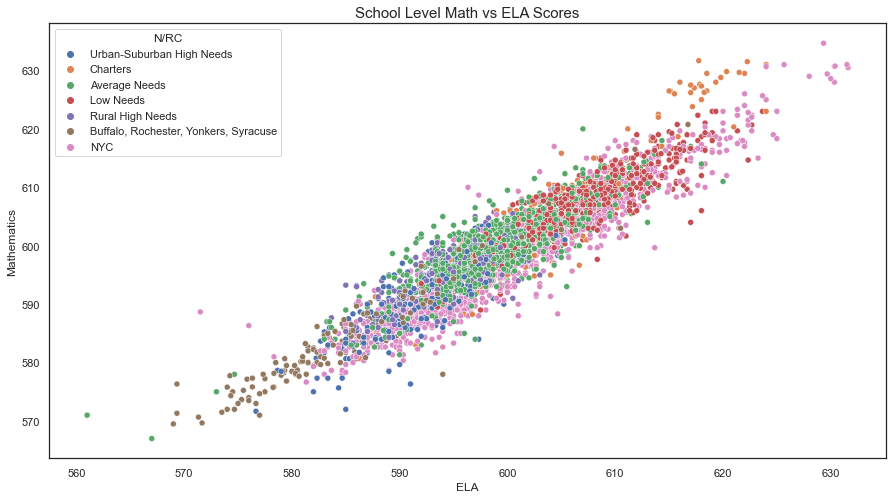

In [108]:
plt.figure(figsize = (15,8))
plt.title('School Level Math vs ELA Scores', size = 15)
sns.scatterplot(x = 'ELA', y = 'Mathematics', data = schoolsEDA, hue = 'N/RC')

<AxesSubplot:title={'center':'District Level Math vs ELA Scores'}, xlabel='ELA', ylabel='Mathematics'>

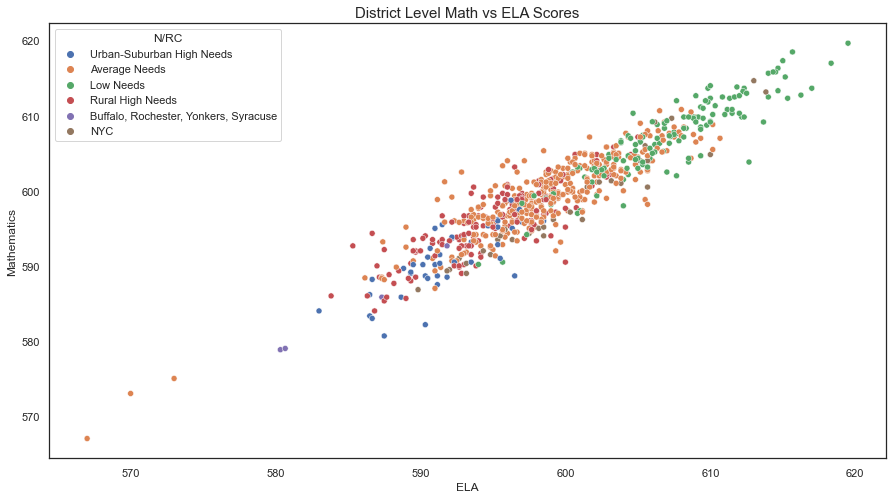

In [109]:
plt.figure(figsize = (15,8))
plt.title('District Level Math vs ELA Scores', size = 15)
sns.scatterplot(x = 'ELA', y = 'Mathematics', data = districtsEDA, hue = 'N/RC')

We notice in the graphs of ELA vs Math scores, hued by N/RC codes for all schools, there is a clear linear relationship. The higher the Math scores, the higher the ELA scores. Moreover we notice that "Large Cities" do the worst in both ELA and MATH. Charter schools do the best in Math. The vast majority of "Low Needs" schools do very well, however, NYC school are so unequal that they are represented at all regions of the graph and a few are among the highest performers in the state (particularly in ELA).

<AxesSubplot:title={'center':'School Level Math Scores vs Free Lunch Rate'}, xlabel='FreeLunch%', ylabel='Mathematics'>

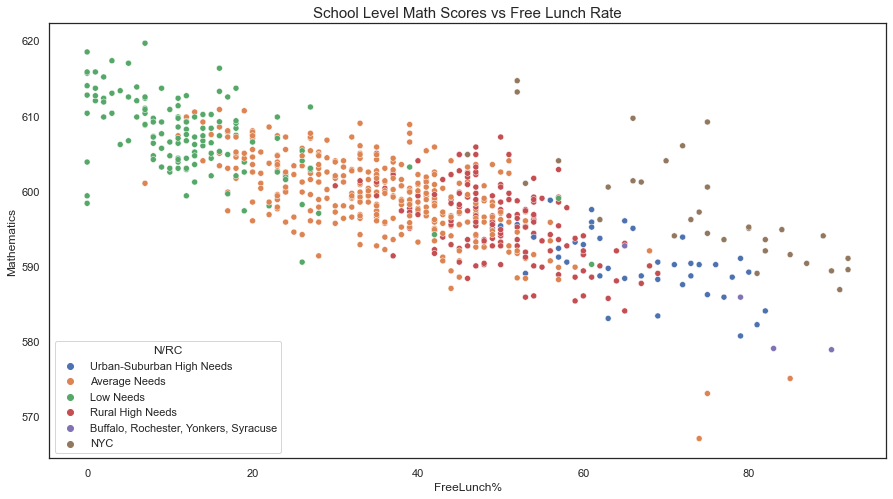

In [110]:
plt.figure(figsize = (15,8))
plt.title('School Level Math Scores vs Free Lunch Rate', size = 15)
sns.scatterplot(x = 'FreeLunch%', y = 'Mathematics', data = districtsEDA, hue = 'N/RC')

<AxesSubplot:title={'center':'District Level Math Scores vs Free Lunch Rate'}, xlabel='FreeLunch%', ylabel='Mathematics'>

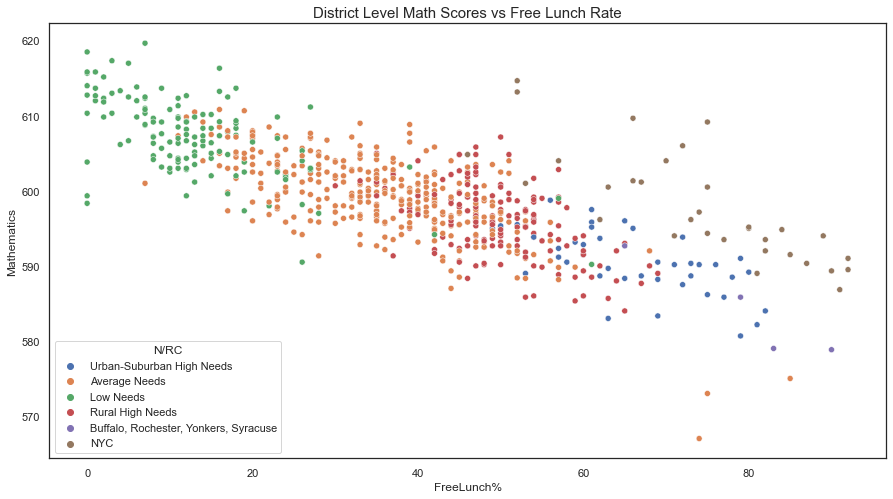

In [111]:
plt.figure(figsize = (15,8))
plt.title('District Level Math Scores vs Free Lunch Rate', size = 15)
sns.scatterplot(x = 'FreeLunch%', y = 'Mathematics', data = districtsEDA, hue = 'N/RC')

The negative relation between Free Lunch Rates and Scores is clearly visible. The stratification of Free Lunch Rates by N/RC Category is also starkly visible. Interestingly, NYC schools have very high Free Lunch Rates but do not necessarily have low Scores.

# Conclusions

The data analyzed for this project presents to us a picture of socio-economic inequality in the State of New York that exists even at the level of children, and reflects in their Grade 3-8 test scores in Mathematics and the English Language Arts.

Some noteworthy findings to our research questions are as follows:

- ELA and Math scores are highly correlated with a clear positive linear relationship.
- There exists a negative correlation between free lunch rates and test scores.
- Girls do significantly better in ELA than boys, but both genders are near-equal in Math scores statewide.
- Two minority racial groups represent the outlying extrema of state score averages in both Math and ELA. Asian-American students score highest in both areas while Black/African-American students score lowest in both. All other racial groups are clustered in the middle.
- Various other labels used to describe potentially-disadvantaged students associate with noticeably lower scores in both ELA and Math when compared to students not bearing such labels. ELL (9% of the state student body), Economically Disadvantaged (57%), Disabled (18%) and Migrant (<1%) students all scored significantly worse on both ELA and Math statewide.
- The inequality of the educational system also extends to Teacher Pay data, where we have found that 5 counties have a median pay for their teachers that is on average (across school districts) over 100,000 dollars pre annum. The contrast between the lowest 5th percentile teacher pay (in the region of 20,000 dollars per annum) and the highest 95th percentile pay (in the region of 160,000 dollars) is stark.

The biggest takeaway from our analysis is that we ***don't*** see a clear relationship between higher teacher pay and better student outcomes, at least in the levels of aggregation we are able to access. In fact, the most surprising result of our analysis is that the very best performing schools in the state are either in NYC (where teacher pay is relatively low), or are charter schools (which do not have publically available teacher pay data), or are among those labeled as "Low Needs" by the NYSED (of which many do have high teacher pays). The performance of students taught by highly-paid teachers improves slightly in a modal sense, but also becomes more variable overall. We deem that the effective doubling of teacher pay that seems to be required to produce a significant difference is probably not the most efficient way for the state to improve its students' outcomes.

To conclude, we re-iterate the notion that socio-economics has a huge impact on education and scholastic outcomes. All factors that correspond to relative poverty associate to worse test scores, while factors that correspond to affluence generally associate to higher test scores.

# References

- U.S. Public Education Spending Statistics : per Pupil + Total. EducationData. (2021, April 22). https://educationdata.org/public-education-spending-statistics#education-spending-by-state. 

- NYSED Data Site. data.nysed.gov. (n.d.). https://data.nysed.gov/.
    - NY STATE - Enrollment Data: NYSED Data Site. data.nysed.gov. (n.d.). https://data.nysed.gov/enrollment.php.

- Teacher Pay. See Through New York. (n.d.). https://www.seethroughny.net/teacher_pay.